# Set up

In [1]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *

setup_random_seeds(42)
device = get_device()

base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

# Model 1: ZCA NLL Loss with SSH+SST input

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32, shuffle=False)

# Load model
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)

        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model 1 evaluation complete!")

# Model 2: SSH input only

# Prepare training data for normalization statistics (SSH only)
x_train_ssh_only = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_normalized_ssh, min_vals_ssh, max_vals_ssh = min_max_normalize(x_train_ssh_only)

# Prepare test data (SSH only)
x_test_ssh_only_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_normalized_ssh, _, _ = min_max_normalize(x_test_ssh_only_original, min_vals_ssh, max_vals_ssh)

# Create test dataset and loader
test_dataset_ssh = TensorDataset(x_test_normalized_ssh, y_test)
test_loader_ssh = DataLoader(test_dataset_ssh, batch_size=32, shuffle=False)

# Load model
model_ssh_only = UNet(in_channels=1, out_channels=2, initial_features=32, depth=4)
model_ssh_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/ssh_input_only.pth', map_location=device)
model_ssh_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_ssh_only.eval()
results_ssh_only = {
    'ssh': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices_ssh = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_ssh):
        
        batch_start = i * test_loader_ssh.batch_size
        batch_end = min(batch_start + test_loader_ssh.batch_size, len(test_dataset_ssh))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_ssh.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_ssh_only(batch_x)
        
        ssh_batch_original = x_test_ssh_only_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_ssh_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_ssh_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_ssh_only['bm_true'].append(bm_true.cpu().numpy())
        results_ssh_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_ssh_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_ssh_only['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_ssh_only['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_ssh_only:
    results_ssh_only[key] = np.concatenate(results_ssh_only[key], axis=0)

print("Model 2 evaluation complete!")

# Model 3: MSE loss only
model_mse_only = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_mse_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/mse_loss_only.pth', map_location=device)
model_mse_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_mse_only.eval()
results_mse_only = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': []
}

sample_indices_mse = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):  
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_mse.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_mse_only(batch_x)
        
        # Use original scale SSH and SST for BM calculation
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # For MSE model, only use mean prediction (no sampling)
        mu_zca_expanded = outputs[:, 0:1, ...]  # Use first channel as mean
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Store results
        results_mse_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_mse_only['sst'].append(sst_batch_original.cpu().numpy())
        results_mse_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_mse_only['bm_true'].append(bm_true.cpu().numpy())
        results_mse_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_mse_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())

for key in results_mse_only:
    results_mse_only[key] = np.concatenate(results_mse_only[key], axis=0)

print("Model 3 evaluation complete!")

# Create xarray datasets and save results
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
    ('ssh_only', results_ssh_only, True, False), 
    ('mse_only', results_mse_only, False, True)
]

# Store all datasets
eval_datasets = {}

for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    
    eval_dataset = create_evaluation_dataset(results, model_name, has_ensembles, has_sst)
    
    # Store the dataset
    eval_datasets[model_name] = eval_dataset


Using device: cpu


/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x79605d7f4680>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x79605d7f4680>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x79605d7f4680>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/tmp/ipykernel_188/2914359427.p

Model 1 evaluation complete!


/tmp/ipykernel_188/2914359427.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/ssh_input_only.pth', map_locati

Model 2 evaluation complete!


/tmp/ipykernel_188/2914359427.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/mse_loss_only.pth', map_locatio

Model 3 evaluation complete!
Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for ssh_only...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for mse_only...


# Data Structure View

In [2]:
eval_datasets['sst_ssh'].ubm_truth
eval_datasets['sst_ssh'].bm_truth
eval_datasets['sst_ssh'].ubm_pred_mean
eval_datasets['sst_ssh'].bm_pred_mean.shape

(3645, 80, 80)

In [ ]:
eval_datasets['ssh_only']

In [4]:
eval_datasets['mse_only']

<xarray.Dataset> Size: 560MB
Dimensions:        (sample: 3645, i: 80, j: 80)
Coordinates:
  * sample         (sample) int64 29kB 0 1 2 3 4 5 ... 3640 3641 3642 3643 3644
  * i              (i) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
  * j              (j) int64 640B 0 1 2 3 4 5 6 7 8 ... 72 73 74 75 76 77 78 79
Data variables:
    ssh            (sample, i, j) float32 93MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ubm_truth      (sample, i, j) float32 93MB nan nan nan nan ... nan nan nan
    bm_truth       (sample, i, j) float32 93MB nan nan nan nan ... nan nan nan
    ubm_pred_mean  (sample, i, j) float32 93MB -0.002933 -0.003443 ... 0.007049
    bm_pred_mean   (sample, i, j) float32 93MB 0.002933 0.003443 ... -0.007049
    sst            (sample, i, j) float32 93MB 0.06335 0.05314 ... 0.0 0.0

# Figure 2

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import cmocean.cm as cmo
from sklearn.metrics import r2_score

# Constants 
g = 9.81       
dx = 1500.0   # m   (1.5 km grid)
dy = 1500.0   # m
f_cor = -8.6e-5  #  (Agulhas region)

def flatten_clean(da, clean_idx):
    return da.isel(sample=clean_idx).stack(pixels=("i", "j")).values

def calculate_geostrophic_speed(field):
    """Calculate the geostrophic speed from a 2D field of sea surface height."""
    dη_dy = np.gradient(field, dy, axis=0, edge_order=2)
    dη_dx = np.gradient(field, dx, axis=1, edge_order=2)
    u_g = -g / f_cor * dη_dy
    v_g = g / f_cor * dη_dx
    speed = np.sqrt(u_g**2 + v_g**2)
    return speed

def find_extreme_samples(model_pred, truth, clean_idx, model_name="Selected Model"):
    """Find sample indices with maximum, median, and minimum R² values"""
    r2_vals = []
    
    for t, p in zip(flatten_clean(truth, clean_idx), flatten_clean(model_pred, clean_idx)):
        m = np.isfinite(t) & np.isfinite(p)
        if m.sum() < 2:
            r2_vals.append(np.nan)
        else:
            r2_vals.append(r2_score(t[m], p[m]))
    
    r2_vals = np.array(r2_vals)
    non_nan_indices = np.where(~np.isnan(r2_vals))[0]
    valid_r2 = r2_vals[non_nan_indices]
    
    max_local_idx = np.argmax(valid_r2)
    min_local_idx = np.argmin(valid_r2)
    sorted_indices = np.argsort(valid_r2)
    median_local_idx = sorted_indices[len(sorted_indices) // 2]
    
    max_sample_idx = clean_idx[non_nan_indices[max_local_idx]]
    min_sample_idx = clean_idx[non_nan_indices[min_local_idx]]
    median_sample_idx = clean_idx[non_nan_indices[median_local_idx]]
    
    
    return {
        "max": {"sample_idx": int(max_sample_idx), "r2": float(valid_r2[max_local_idx])},
        "median": {"sample_idx": int(median_sample_idx), "r2": float(valid_r2[median_local_idx])},
        "min": {"sample_idx": int(min_sample_idx), "r2": float(valid_r2[min_local_idx])}
    }

def format_ax(ax, title=None, row_label=None):
    """Format axis for 4x4 comparison plots"""
    size = 80
    title_fontsize = 32
    title_pad = 15
    
    tick_positions = np.linspace(0, size-1, 9)
    tick_positions = np.round(tick_positions).astype(int)
    
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='major', length=6, width=1.5, color='black')
    
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize, pad=title_pad, fontweight='bold')
    
    if row_label:
        ax.text(-0.15, 0.5, row_label, transform=ax.transAxes, 
                fontsize=title_fontsize, ha='center', va='center', rotation=90,
                fontweight='bold')

def format_ax_ssh(ax, title):
    """Format axis for SSH plots"""
    size = 80
    title_fontsize = 28
    title_pad = 15

    # Calculate tick positions in pixel units - 8 sections of 10 pixels each
    tick_positions = np.linspace(0, size-1, 9)  # 9 points to create 8 sections
    tick_positions = np.round(tick_positions).astype(int)  # Round to integers
    
    # Calculate km values (each pixel = 1.5km)
    km_ticks = tick_positions * 1.5
    
    # Set ticks
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    # Add km labels every other tick (show labels at positions 0, 2, 4, 6, 8)
    x_labels = []
    y_labels = []
    for i, km in enumerate(km_ticks):
        if i % 2 == 0:  # Every even index (0, 2, 4, 6, 8)
            x_labels.append(f'{km:.0f}')
            y_labels.append(f'{km:.0f}')
        else:
            x_labels.append('')  # Empty string for odd indices
            y_labels.append('')  # Empty string for odd indices
    
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    # Make ticks and labels more visible
    ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=26)
    
    # Set title
    ax.set_title(title, fontsize=title_fontsize, pad=title_pad, loc='center', fontweight='bold')
    
    # Add km labels to axes
    ax.set_xlabel('Distance (km)', fontsize=28)



# Clean sample mask (no NaNs in truth UBM)
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx = np.where(clean_mask)[0]

# Find extreme samples for each model using their UBM predictions
extreme_samples = {}

# For ZCA+SST model
extreme_samples['sst_ssh'] = find_extreme_samples(
    eval_datasets['sst_ssh'].ubm_pred_mean, 
    test.ubm, clean_idx, 
    model_name="ZCA+SST"
)

# For SSH-only model  
extreme_samples['ssh_only'] = find_extreme_samples(
    eval_datasets['ssh_only'].ubm_pred_mean, 
    test.ubm, clean_idx, 
    model_name="SSH-only"
)

# For MSE-only model
extreme_samples['mse_only'] = find_extreme_samples(
    eval_datasets['mse_only'].ubm_pred_mean, 
    test.ubm, clean_idx, 
    model_name="MSE-only"
)

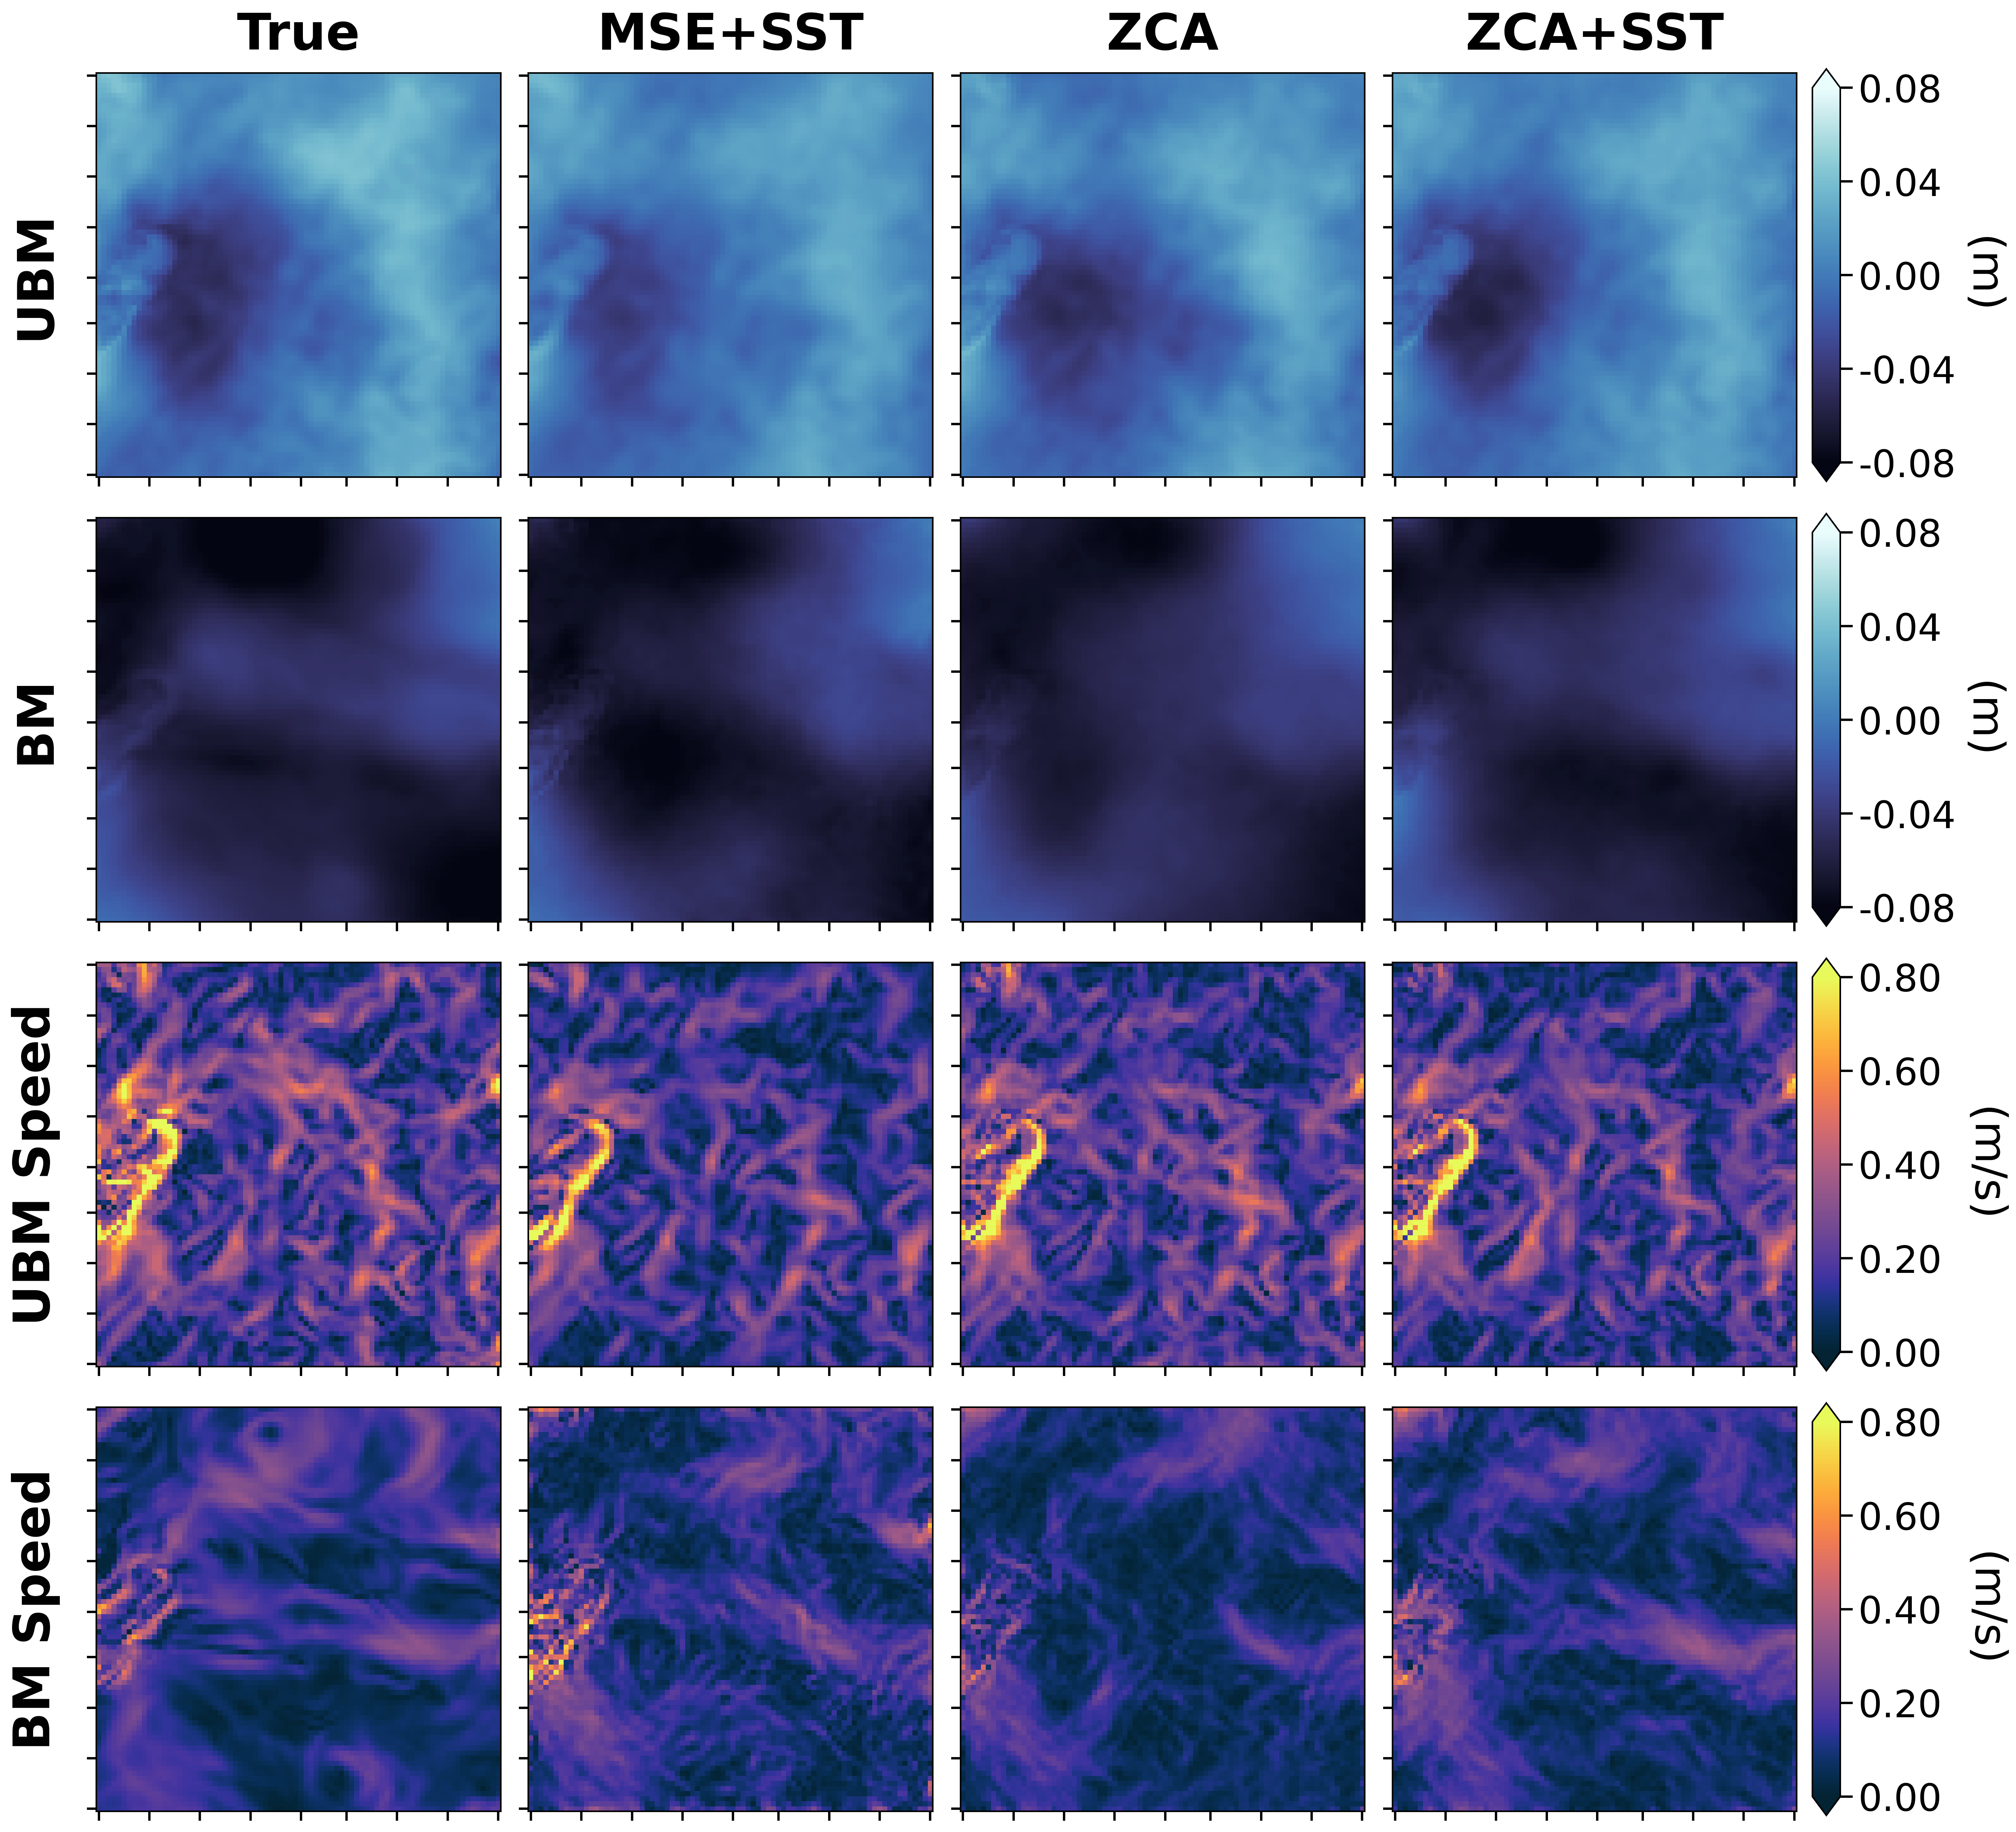

Best sample comparison saved (Sample #3041, R²=0.9127)


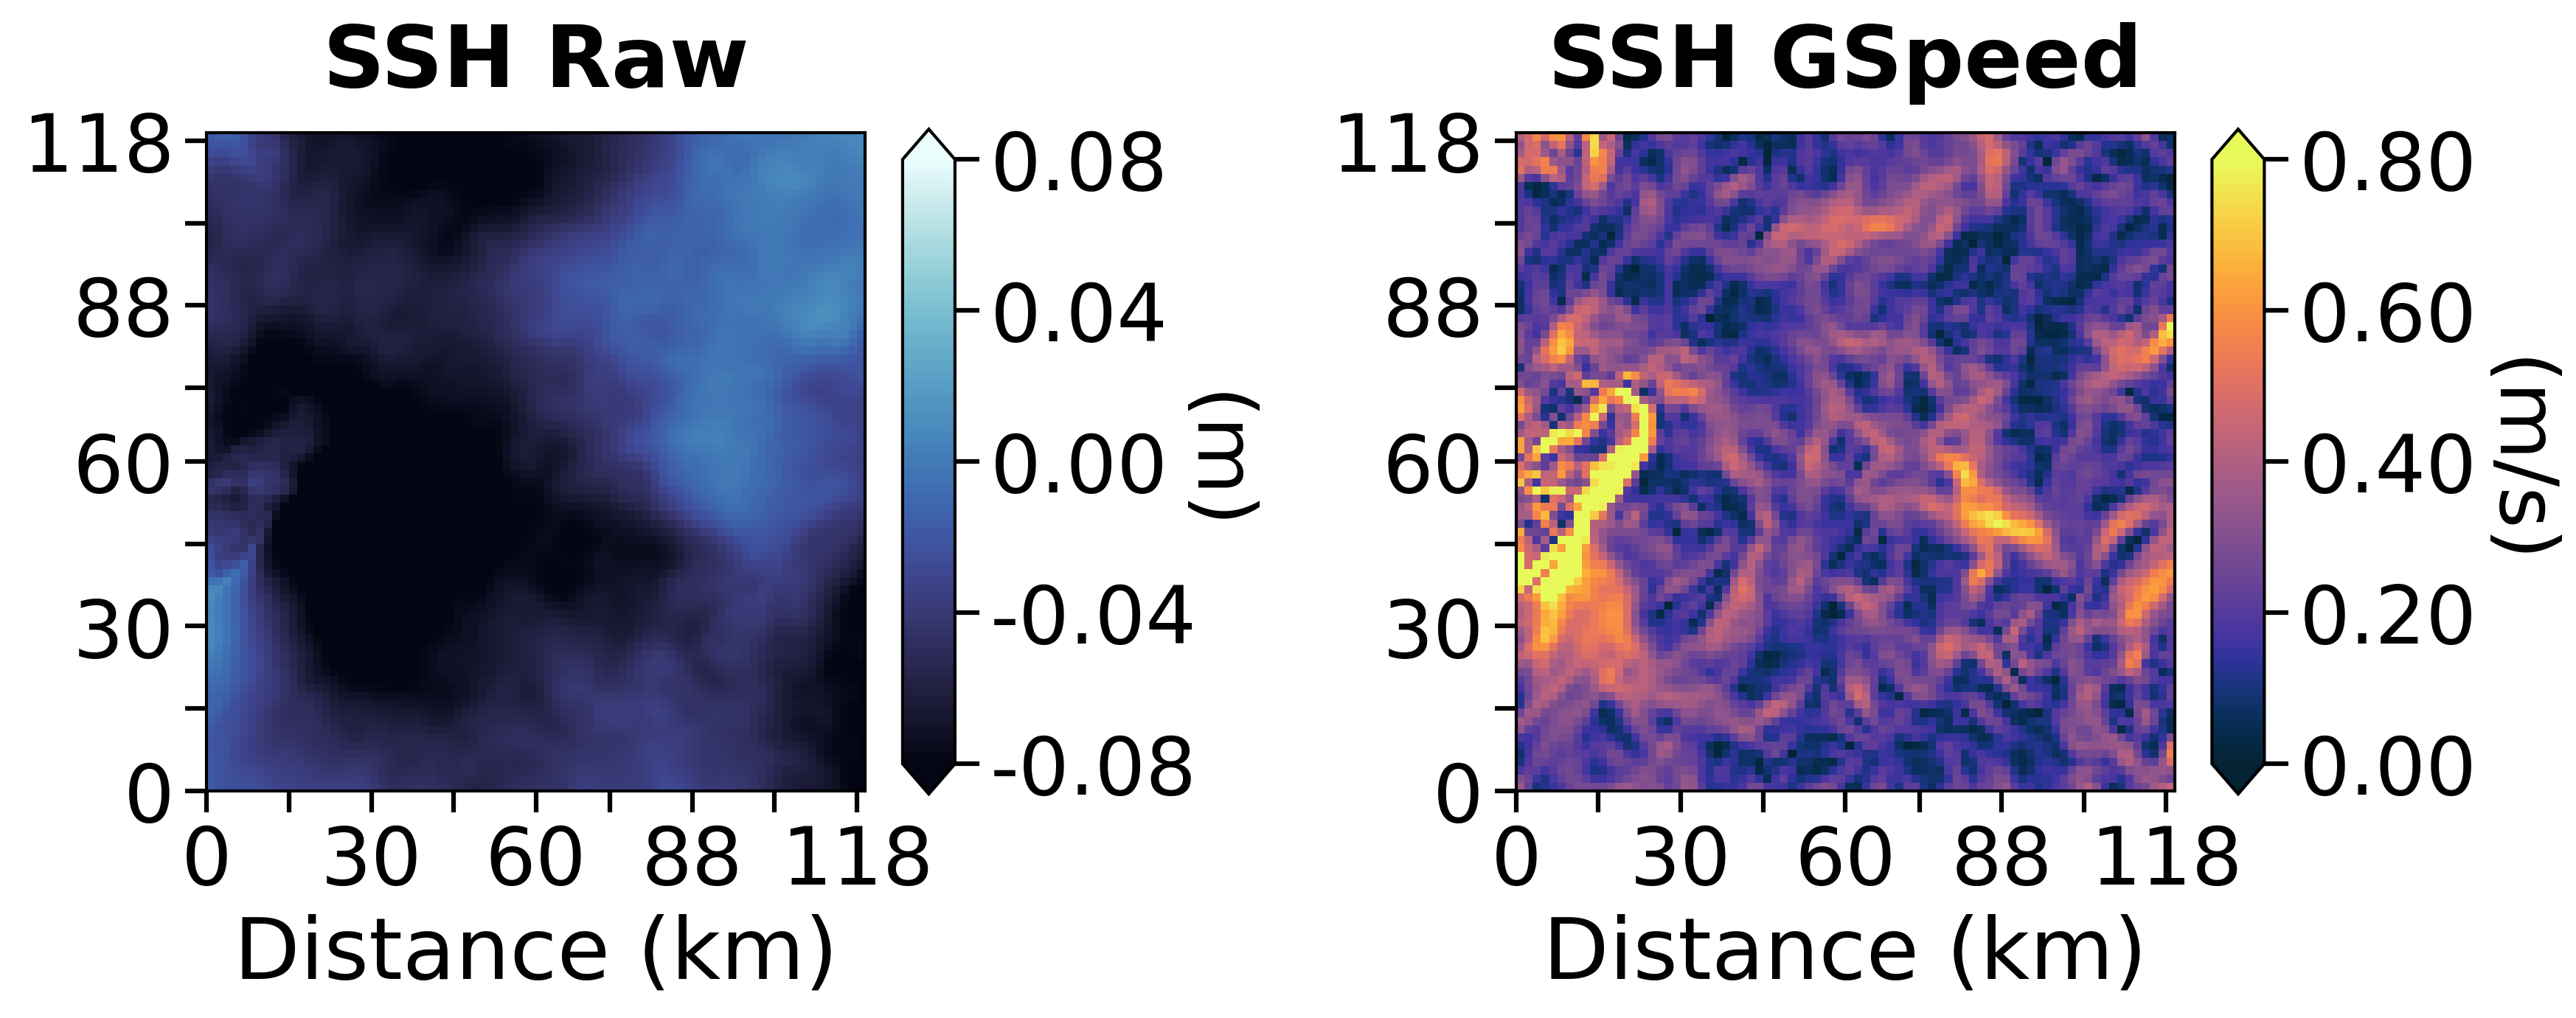

Best SSH visualization saved (Sample #3041, R²=0.9127)


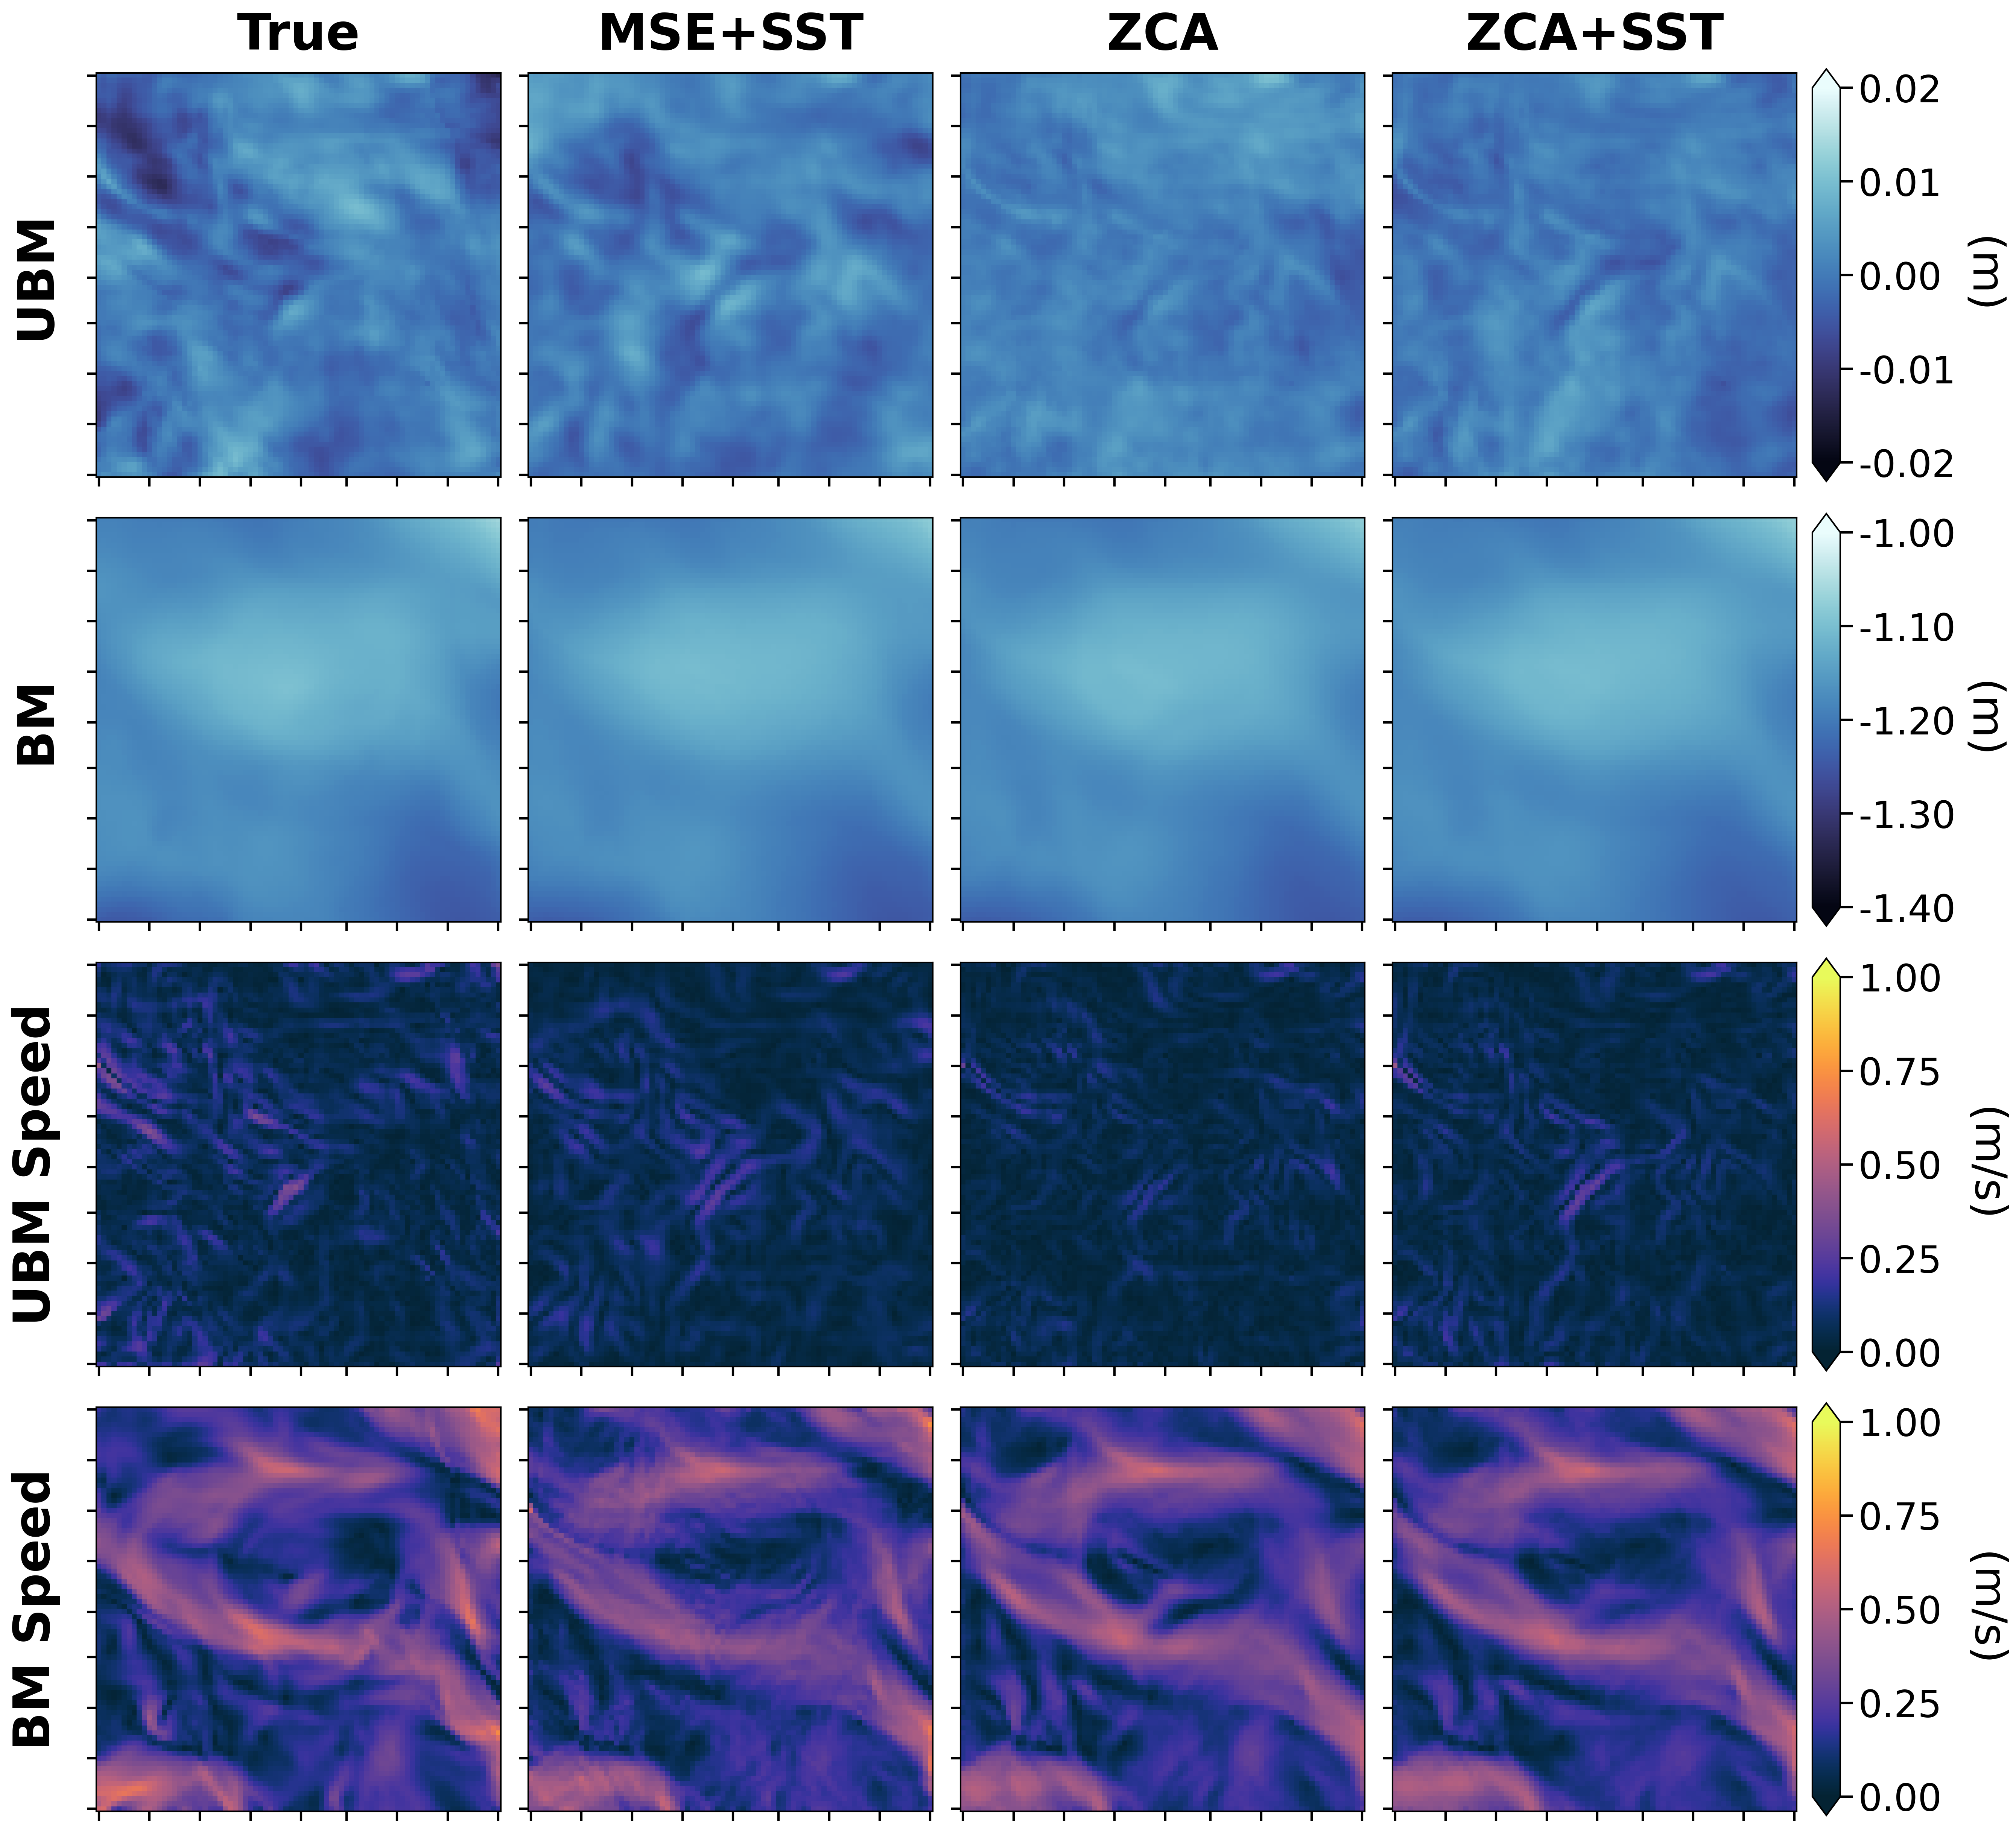

Median sample comparison saved (Sample #519, R²=0.0866)


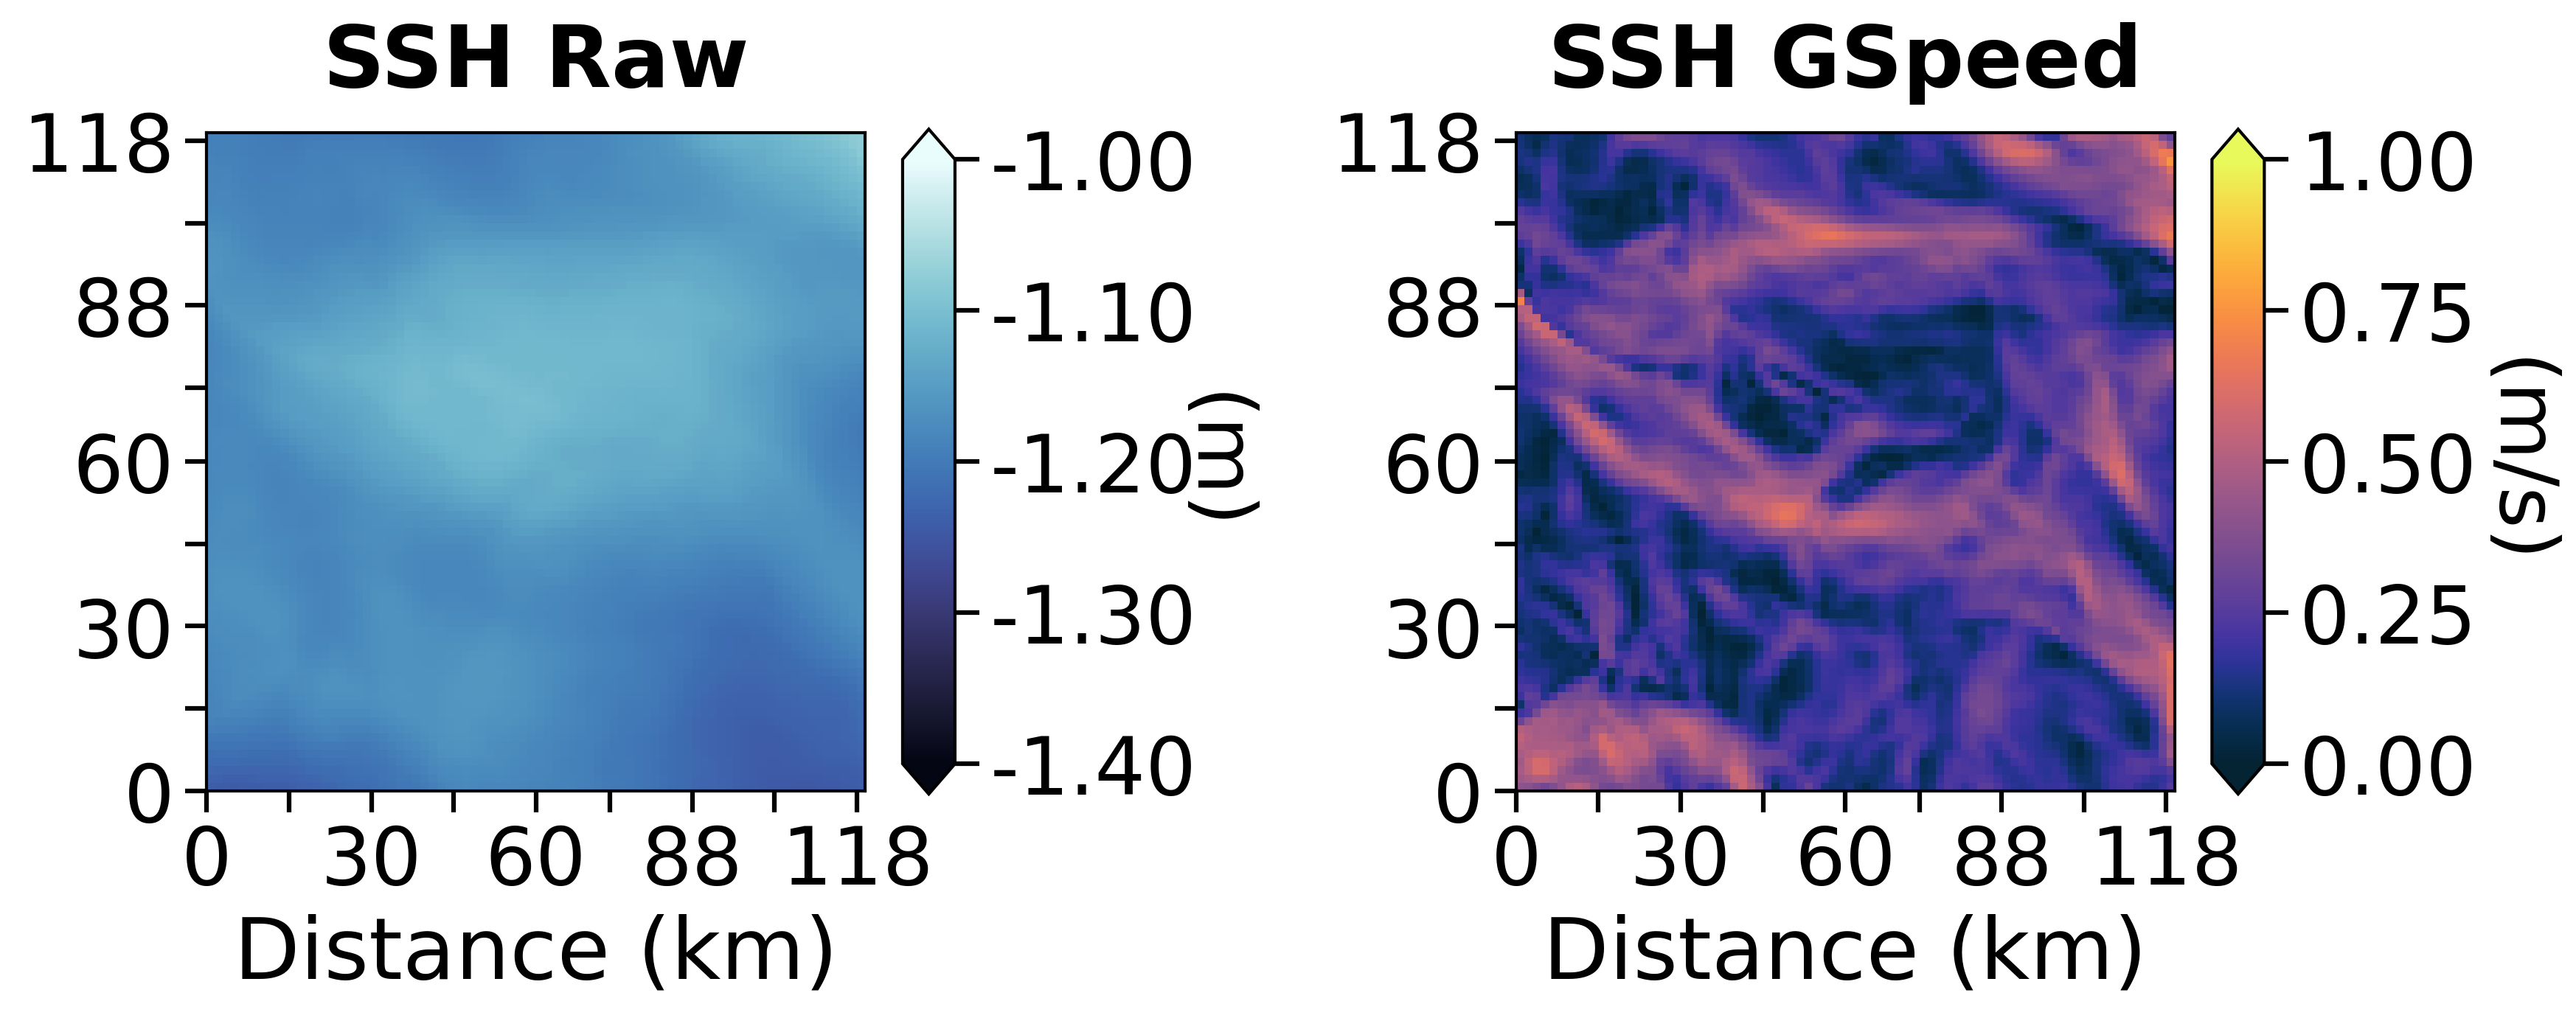

Median SSH visualization saved (Sample #519, R²=0.0866)


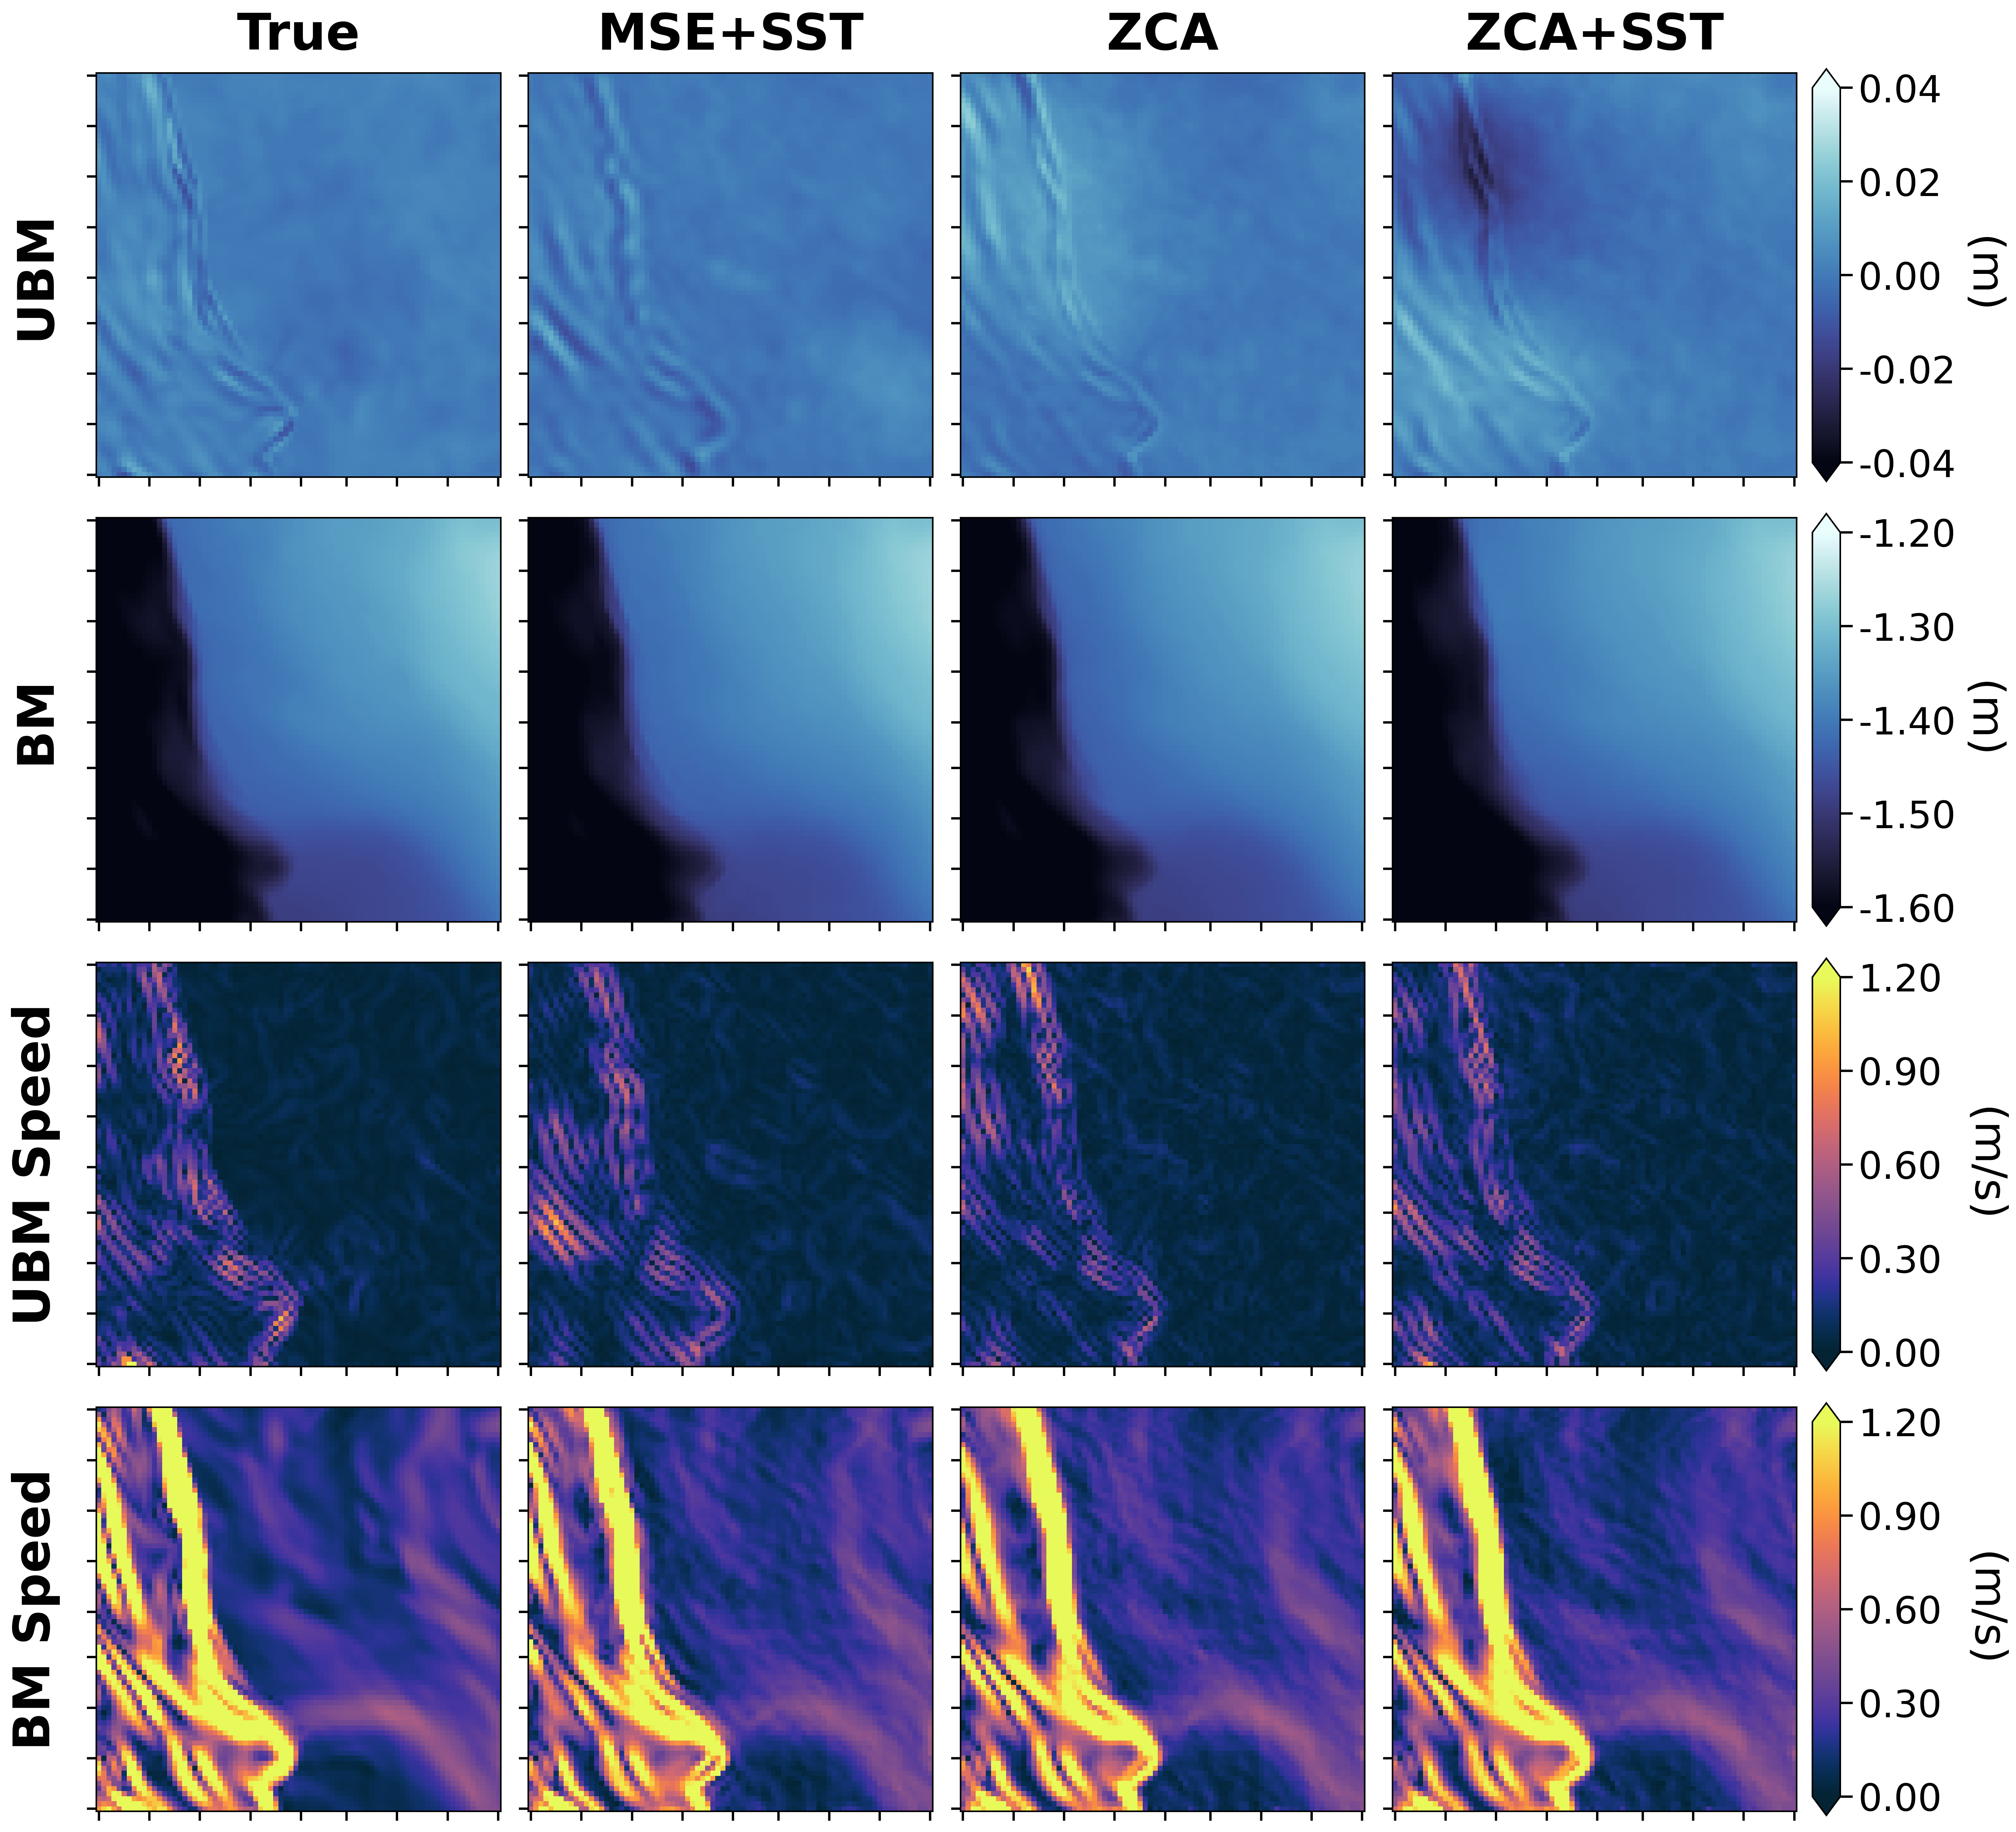

Worst sample comparison saved (Sample #3323, R²=-6.2663)


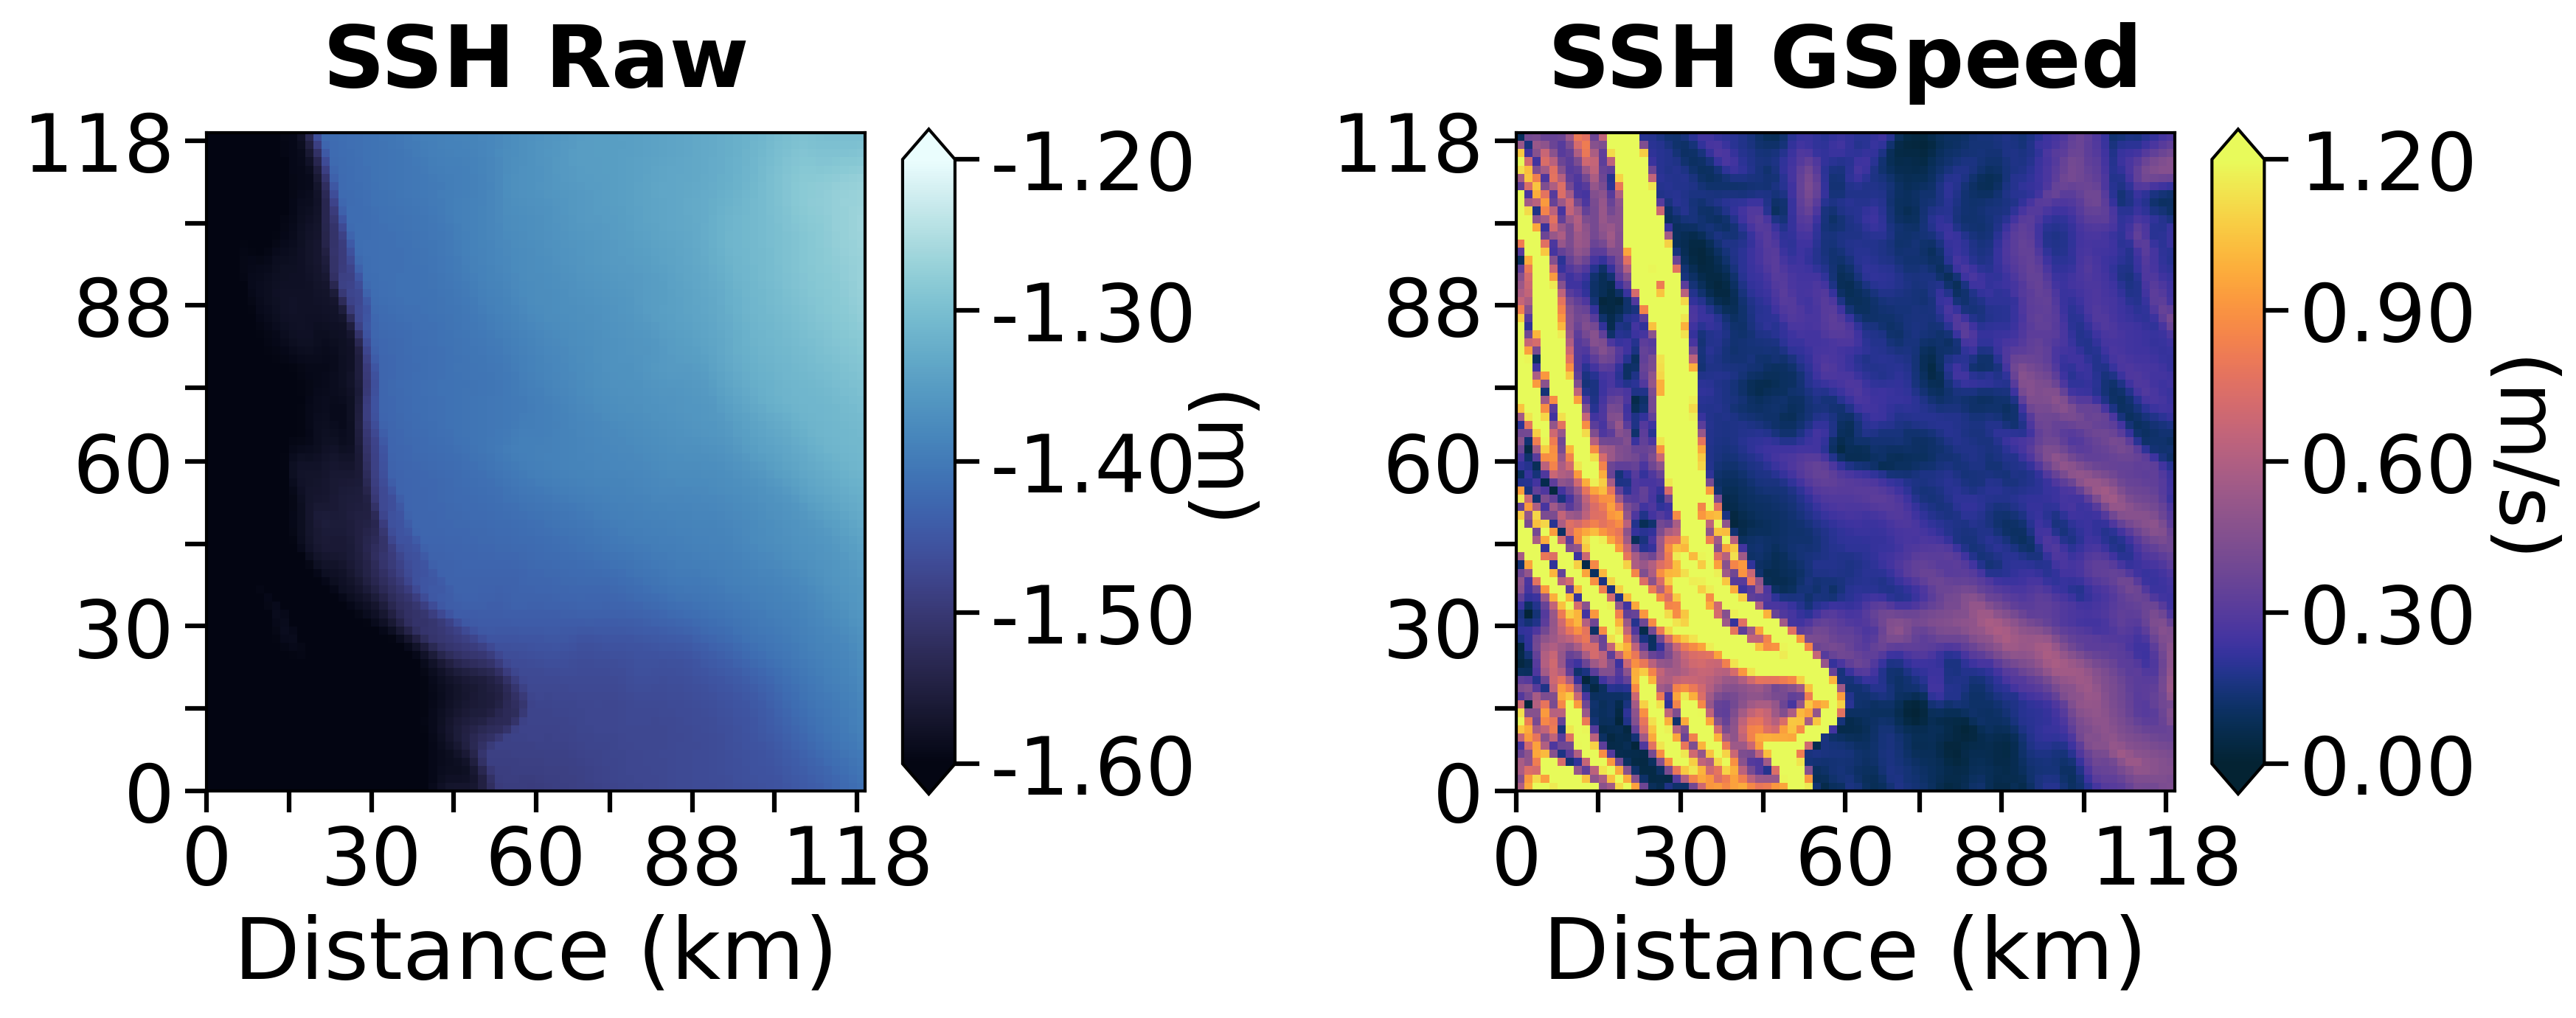

Worst SSH visualization saved (Sample #3323, R²=-6.2663)


In [6]:
# Function to create the 4x4 comparison plot
def create_comparison_plot(sample_idx, sample_type, r2_value, 
                          vmin_ubm=-0.04, vmax_ubm=0.04,
                          vmin_bm=-0.1, vmax_bm=0.1,
                          vmin_grad=0.0, vmax_grad=0.8):
    """Create 4x4 comparison plot for UBM, BM, and speeds"""
    
    # Extract data for the sample
    ssh_true = test.ssh.isel(sample=sample_idx).values
    ubm_true = test.ubm.isel(sample=sample_idx).values  
    bm_true = test.bm.isel(sample=sample_idx).values

    # Model predictions for the sample
    ubm_pred_sst_ssh = eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=sample_idx).values
    ubm_pred_ssh_only = eval_datasets['ssh_only'].ubm_pred_mean.isel(sample=sample_idx).values
    ubm_pred_mse_only = eval_datasets['mse_only'].ubm_pred_mean.isel(sample=sample_idx).values

    # Calculate BM from UBM predictions
    bm_pred_sst_ssh = ssh_true - ubm_pred_sst_ssh
    bm_pred_ssh_only = ssh_true - ubm_pred_ssh_only
    bm_pred_mse_only = ssh_true - ubm_pred_mse_only

    # Calculate geostrophic speeds
    ubm_true_speed = calculate_geostrophic_speed(ubm_true)
    ubm_pred_sst_ssh_speed = calculate_geostrophic_speed(ubm_pred_sst_ssh)
    ubm_pred_ssh_only_speed = calculate_geostrophic_speed(ubm_pred_ssh_only)
    ubm_pred_mse_only_speed = calculate_geostrophic_speed(ubm_pred_mse_only)

    bm_true_speed = calculate_geostrophic_speed(bm_true)
    bm_pred_sst_ssh_speed = calculate_geostrophic_speed(bm_pred_sst_ssh)
    bm_pred_ssh_only_speed = calculate_geostrophic_speed(bm_pred_ssh_only)
    bm_pred_mse_only_speed = calculate_geostrophic_speed(bm_pred_mse_only)

    # Create figure
    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = gridspec.GridSpec(4, 5, width_ratios=[1, 1, 1, 1, 0.05], 
                          height_ratios=[1, 1, 1, 1], wspace=0.01, hspace=0.1)

    col_titles = ['True', 'MSE+SST', 'ZCA', 'ZCA+SST']
    row_types = ['UBM', 'BM', 'UBM Speed', 'BM Speed']

    all_data = [
        [ubm_true, ubm_pred_mse_only, ubm_pred_ssh_only, ubm_pred_sst_ssh],
        [bm_true, bm_pred_mse_only, bm_pred_ssh_only, bm_pred_sst_ssh],
        [ubm_true_speed, ubm_pred_mse_only_speed, ubm_pred_ssh_only_speed, ubm_pred_sst_ssh_speed],
        [bm_true_speed, bm_pred_mse_only_speed, bm_pred_ssh_only_speed, bm_pred_sst_ssh_speed]
    ]

    all_cmaps = [cmo.ice, cmo.ice, cmo.thermal, cmo.thermal]
    all_vmins = [vmin_ubm, vmin_bm, vmin_grad, vmin_grad]
    all_vmaxs = [vmax_ubm, vmax_bm, vmax_grad, vmax_grad]

    # Define colorbar ticks for each row based on the ranges
    def create_ticks(vmin, vmax, num_ticks=5):
        """Create evenly spaced ticks between vmin and vmax"""
        return np.linspace(vmin, vmax, num_ticks)

    all_ticks = [
        create_ticks(vmin_ubm, vmax_ubm, 5),  # UBM row
        create_ticks(vmin_bm, vmax_bm, 5),    # BM row
        create_ticks(vmin_grad, vmax_grad, 5), # UBM Speed row
        create_ticks(vmin_grad, vmax_grad, 5)  # BM Speed row
    ]

    # Plot all rows
    for row in range(4):
        for col, data in enumerate(all_data[row]):
            ax = fig.add_subplot(gs[row, col])
            im = ax.imshow(data, cmap=all_cmaps[row], vmin=all_vmins[row], vmax=all_vmaxs[row])
            
            col_title = col_titles[col] if row == 0 else None
            row_label = row_types[row] if col == 0 else None
            
            format_ax(ax, title=col_title, row_label=row_label)
            
            if col == 0:
                first_im = im
        
        # Add colorbar for each row
        cax = fig.add_subplot(gs[row, 4])
        cbar = plt.colorbar(first_im, cax=cax, extend='both')
        
        # Style colorbar
        pos = cax.get_position()
        new_pos = [pos.x0 * 1.0, pos.y0 + pos.height * -0.01, pos.width * 1.3, pos.height * 1.02]
        cax.set_position(new_pos)
        
        cbar.set_ticks(all_ticks[row])
        
        # Format colorbar ticks to 2 decimal places
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        
        if row < 2:
            cbar.ax.set_ylabel('(m)', rotation=270, labelpad=30, fontsize=28)
        else:
            cbar.ax.set_ylabel('(m/s)', rotation=270, labelpad=40, fontsize=28)
        
        cbar.ax.tick_params(axis='y', length=8, width=1.5, labelsize=24)

    # Save figure
    plt.savefig(f'/home/jovyan/GRL_ssh/figures/Figure_2/{sample_type}_sample_comparison.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.savefig(f'/home/jovyan/GRL_ssh/figures/Figure_2/{sample_type}_sample_comparison.pdf', 
                dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    print(f"{sample_type.capitalize()} sample comparison saved (Sample #{sample_idx}, R²={r2_value:.4f})")

def create_ssh_plot(sample_idx, sample_type, r2_value,
                   vmin_ssh=-0.04, vmax_ssh=0.04,
                   vmin_grad=0.0, vmax_grad=0.8):
    """Create 1x2 SSH plot"""
    
    # Extract SSH data
    ssh_sample = test.ssh.isel(sample=sample_idx).values
    ssh_grad_sample = calculate_geostrophic_speed(ssh_sample)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), dpi=300)
    fig.subplots_adjust(wspace=0.75)  

    # Panel A: SSH Raw
    im1 = ax1.imshow(ssh_sample, cmap=cmo.ice, vmin=vmin_ssh, vmax=vmax_ssh, 
                     extent=[0, 80, 0, 80])
    format_ax_ssh(ax1, 'SSH Raw')

    # Colorbar for Panel A with custom ticks
    cbar1 = plt.colorbar(im1, ax=ax1, pad=0.05, aspect=12.7, fraction=0.07, extend='both')
    cbar1.set_label('(m)', rotation=270, fontsize=26, labelpad=18)
    
    # Set custom ticks for SSH colorbar
    ssh_ticks = np.linspace(vmin_ssh, vmax_ssh, 5)
    cbar1.set_ticks(ssh_ticks)
    
    cbar1.ax.tick_params(labelsize=26, length=8, width=1.5)
    cbar1.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Panel B: SSH Gradient Speed
    im2 = ax2.imshow(ssh_grad_sample, cmo.thermal, vmin=vmin_grad, vmax=vmax_grad, 
                     extent=[0, 80, 0, 80])
    format_ax_ssh(ax2, 'SSH GSpeed')

    # Colorbar for Panel B with custom ticks
    cbar2 = plt.colorbar(im2, ax=ax2, pad=0.05, aspect=12.7, fraction=0.07, extend='both')
    cbar2.set_label('(m/s)', rotation=270, fontsize=26, labelpad=25)
    
    # Set custom ticks for gradient speed colorbar
    grad_ticks = np.linspace(vmin_grad, vmax_grad, 5)
    cbar2.set_ticks(grad_ticks)
    
    cbar2.ax.tick_params(labelsize=26, length=8, width=1.5)
    cbar2.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Ensure equal aspect ratios
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')

    # Save figure
    plt.savefig(f'/home/jovyan/GRL_ssh/figures/Figure_2/{sample_type}_ssh_comparison.png', 
               dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', format='png')
    plt.savefig(f'/home/jovyan/GRL_ssh/figures/Figure_2/{sample_type}_ssh_comparison.pdf', 
               bbox_inches='tight', facecolor='white', edgecolor='none', format='pdf')
    
    plt.show()
    print(f"{sample_type.capitalize()} SSH visualization saved (Sample #{sample_idx}, R²={r2_value:.4f})")


    
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'axes.linewidth': 1.0,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.minor.width': 0.8,
    'ytick.minor.width': 0.8,
    'lines.linewidth': 1.5,
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

title_fontsize = 32
title_pad = 15


sample_types = ['best', 'median', 'worst']
sample_keys = ['max', 'median', 'min']

# Define custom color ranges for each sample type
color_ranges = {
    'best': {
        'vmin_ubm': -0.08, 'vmax_ubm': 0.08,
        'vmin_bm': -0.08, 'vmax_bm': 0.08,
        'vmin_grad': 0.0, 'vmax_grad': 0.8,
        'vmin_ssh': -0.08, 'vmax_ssh': 0.08
    },
    'median': {
        'vmin_ubm': -0.02, 'vmax_ubm': 0.02,
        'vmin_bm': -1.4, 'vmax_bm': -1.0,
        'vmin_grad': 0.0, 'vmax_grad': 1.0,
        'vmin_ssh': -1.4, 'vmax_ssh': -1.0
    },
    'worst': {
        'vmin_ubm': -0.04, 'vmax_ubm': 0.04,
        'vmin_bm': -1.6, 'vmax_bm': -1.2,
        'vmin_grad': 0.0, 'vmax_grad': 1.2,
        'vmin_ssh': -1.6, 'vmax_ssh': -1.2
    }
}



for sample_type, sample_key in zip(sample_types, sample_keys):
    sample_idx = extreme_samples['sst_ssh'][sample_key]['sample_idx']
    r2_value = extreme_samples['sst_ssh'][sample_key]['r2']
    ranges = color_ranges[sample_type]
    
    
    # Create 4x4 comparison plot with custom ranges
    create_comparison_plot(sample_idx, sample_type, r2_value,
                          vmin_ubm=ranges['vmin_ubm'], vmax_ubm=ranges['vmax_ubm'],
                          vmin_bm=ranges['vmin_bm'], vmax_bm=ranges['vmax_bm'],
                          vmin_grad=ranges['vmin_grad'], vmax_grad=ranges['vmax_grad'])
    
    # Create 1x2 SSH plot with custom ranges
    create_ssh_plot(sample_idx, sample_type, r2_value,
                   vmin_ssh=ranges['vmin_ssh'], vmax_ssh=ranges['vmax_ssh'],
                   vmin_grad=ranges['vmin_grad'], vmax_grad=ranges['vmax_grad'])


# Figure 1 (Stats)

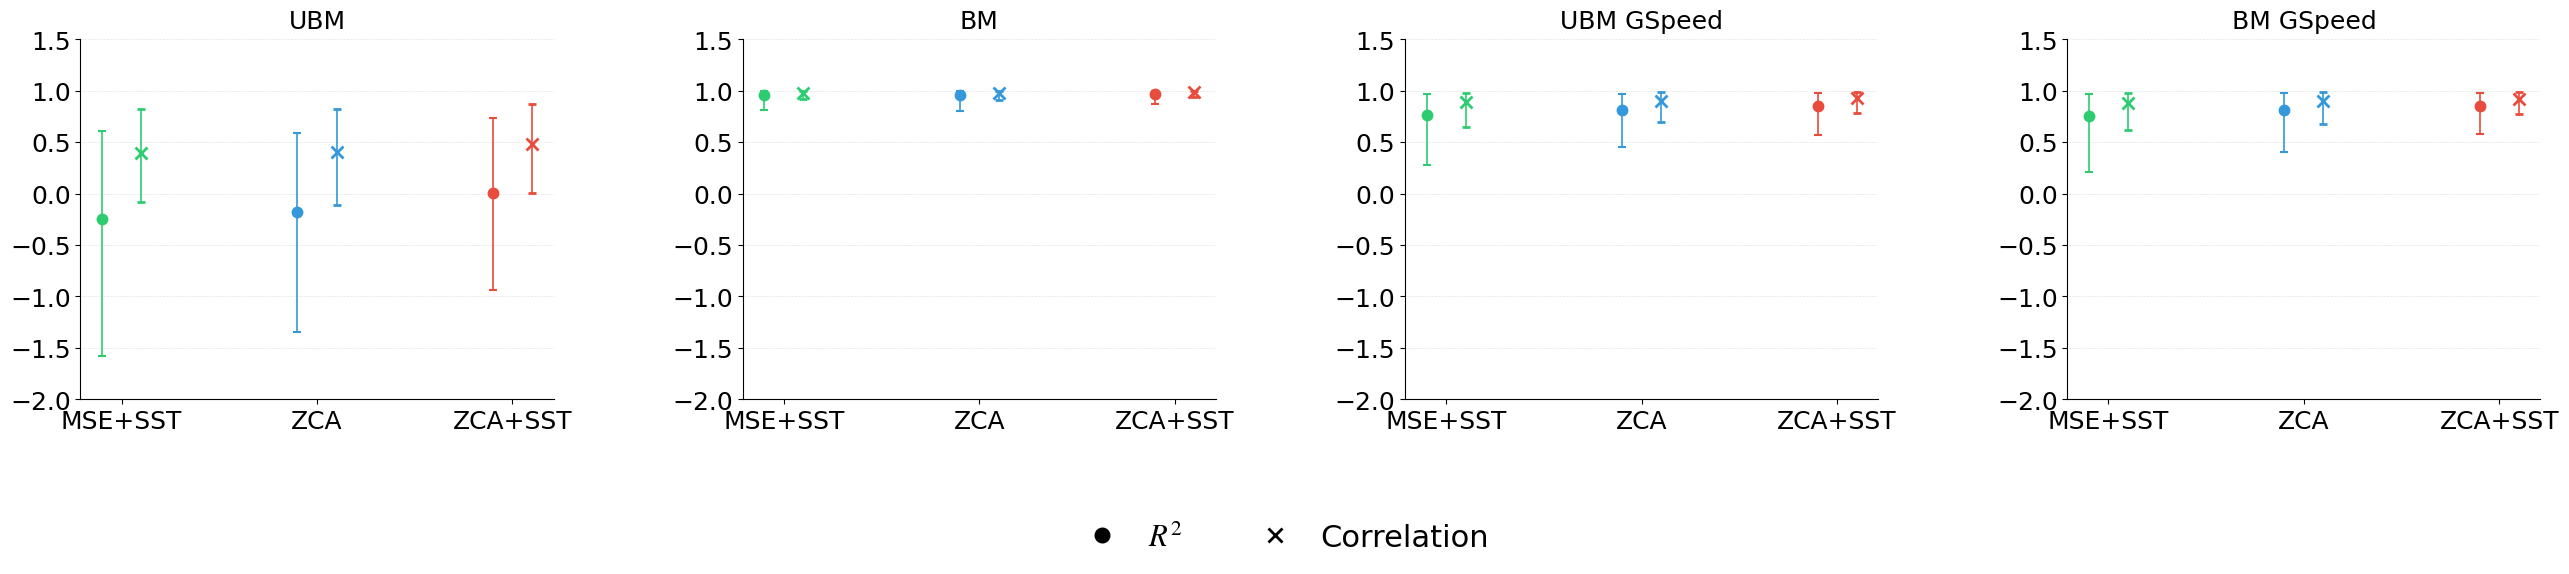

In [7]:
import numpy as np
import matplotlib.pyplot as plt

models    = ["MSE+SST", "ZCA", "ZCA+SST"]
variables = ["UBM", "BM", "UBM GSpeed", "BM GSpeed"]

# R^2
r2_mean = np.array([
    [-0.25, 0.96, 0.76, 0.75],   # MSE+SST
    [-0.18, 0.96, 0.81, 0.81],   # ZCA
    [ 0.01, 0.97, 0.85, 0.85],   # ZCA+SST
])
r2_p5 = np.array([
    [-1.58, 0.81, 0.28, 0.21],
    [-1.35, 0.80, 0.45, 0.40],
    [-0.94, 0.87, 0.57, 0.58],
])
r2_p95 = np.array([
    [0.61, 1.00, 0.97, 0.97],
    [0.59, 1.00, 0.97, 0.98],
    [0.73, 1.00, 0.98, 0.98],
])

# Correlation
corr_mean = np.array([
    [0.39, 0.98, 0.89, 0.88],   # MSE+SST
    [0.40, 0.98, 0.90, 0.90],   # ZCA
    [0.48, 0.99, 0.93, 0.92],   # ZCA+SST
])
corr_p5 = np.array([
    [-0.08, 0.92, 0.65, 0.62],
    [-0.11, 0.91, 0.70, 0.68],
    [0.01, 0.94, 0.78, 0.77],
])
corr_p95 = np.array([
    [0.82, 1.00, 0.98, 0.98],
    [0.82, 1.00, 0.99, 0.99],
    [0.87, 1.00, 0.99, 0.99],
])

# ---------------------------
# ---------------------------
color_map = {
    "MSE+SST": "#2ECC71",  
    "ZCA":     "#3498DB",   
    "ZCA+SST": "#E74C3C",  
}

# styling parameters
cap_size = 3
marker_size = 7
line_width = 1.2
mark_edge_width = 1.5

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Helvetica', 'Arial', 'sans-serif'],
    'font.size': 24,  
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'lines.linewidth': line_width,
    'patch.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

def combined_points(ax, r2_means, r2_p5, r2_p95, corr_means, corr_p5, corr_p95, var_name, is_first=False):
    """Plot both R² (dots) and correlation (crosses) with confidence intervals."""
    x = np.arange(len(models))
    
    # Plot R^2 values with dots
    for i, m in enumerate(models):
        r2_mean = r2_means[i]
        r2_low  = r2_p5[i]
        r2_high = r2_p95[i]
        
        ax.errorbar(
            i - 0.1, r2_mean,  # slight offset to avoid overlap
            yerr=[[r2_mean - r2_low], [r2_high - r2_mean]],
            fmt='o', color=color_map[m], 
            markersize=marker_size, capsize=cap_size, 
            linewidth=line_width, markeredgewidth=mark_edge_width,
            capthick=line_width, alpha=1.0,
            label=f"{m} ($R^2$)" if is_first else None
        )
    
    # Plot correlation values with crosses
    for i, m in enumerate(models):
        corr_mean = corr_means[i]
        corr_low  = corr_p5[i]
        corr_high = corr_p95[i]
        
        ax.errorbar(
            i + 0.1, corr_mean,  # slight offset to avoid overlap
            yerr=[[corr_mean - corr_low], [corr_high - corr_mean]],
            fmt='x', color=color_map[m], 
            markersize=marker_size + 2, capsize=cap_size, 
            linewidth=line_width, markeredgewidth=mark_edge_width + 0.5,
            capthick=line_width, alpha=1.0,
            label=f"{m} (Corr)" if is_first else None
        )
    
    ax.set_title(var_name, fontsize=18, pad=8)
    
    # Set y-limits
    ax.set_ylim(-2, 1.5)
    ax.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5])
    
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.grid(axis="y", linestyle=":", linewidth=0.4, alpha=0.5, color='gray')

# ---------------------------
# Create 1x4 subplot
# ---------------------------
fig, axes = plt.subplots(1, 4, figsize=(30, 6))  
plt.subplots_adjust(left=0.1, right=0.92, top=0.85, bottom=0.25, wspace=0.4)

# Plot all variables
for j, var in enumerate(variables):
    combined_points(
        axes[j],
        r2_mean[:, j], r2_p5[:, j], r2_p95[:, j],
        corr_mean[:, j], corr_p5[:, j], corr_p95[:, j],
        var_name=var,
        is_first=(j == 0)
    )

# Create legend 
legend_elements = [
    plt.Line2D([0],[0], marker='o', color='w',
               markerfacecolor='black', markersize=10, 
               markeredgecolor='black', markeredgewidth=mark_edge_width,
               label="$R^2$"),
    plt.Line2D([0],[0], marker='x', color='black',
               markersize=10, markeredgewidth=mark_edge_width+0.5,
               label="Correlation", linestyle='None')
]

legend = fig.legend(
    legend_elements, [elem.get_label() for elem in legend_elements],
    loc="lower center", bbox_to_anchor=(0.5, -0.05),
    frameon=False, fontsize=22, handletextpad=0.5, ncol=2
)

plt.savefig("figures/Figure_1/stats.png", dpi=300, bbox_inches="tight", 
           facecolor='white', edgecolor='none')
plt.savefig("figures/Figure_1/stats.pdf", dpi=300, bbox_inches="tight", 
           facecolor='white', edgecolor='none')


# Figure 1 (ESR)

In [8]:
# ESR Plot for BM
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from sklearn.metrics import r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')

def calculate_average_e2sr_from_datasets(eval_datasets, test_data, clean_idx_subset):
    """Calculate average ESR for BM"""
    model_e2sr_sums = {}
    sample_count = 0
    first_sample = True
    
    models = {
        'ZCA+SST': 'sst_ssh',
        'ZCA': 'ssh_only', 
        'MSE+SST': 'mse_only' 
    }
    
    # Process each clean sample
    for sample_idx in clean_idx_subset:
        # Get the true BM for this sample
        true_bm = test_data.bm.isel(sample=sample_idx).values
        
        # Skip samples with NaNs
        if np.any(np.isnan(true_bm)):
            continue
            
        # Calculate PSD of true BM
        try:
            psd_true = calculate_psd_km(true_bm)
            wavenumbers = psd_true[list(psd_true.coords.keys())[0]].values
        except Exception as e:
            continue
        
        # For each model, calculate ESR
        for model_name, dataset_key in models.items():
            try:
                # Get predicted BM for this sample (SSH - UBM_pred)
                ssh_sample = test_data.ssh.isel(sample=sample_idx).values
                ubm_pred = eval_datasets[dataset_key].ubm_pred_mean.isel(sample=sample_idx).values
                pred_bm = ssh_sample - ubm_pred
                
                # Skip if prediction contains NaNs
                if np.any(np.isnan(pred_bm)):
                    continue
                    
                # Calculate PSD of the difference (error)
                error = true_bm - pred_bm
                psd_diff = calculate_psd_km(error)
                
                # Calculate E2SR: PSD(error) / PSD(true)
                e2sr = psd_diff.values / psd_true.values
                
                # Initialize sum on first valid sample
                if first_sample or model_name not in model_e2sr_sums:
                    model_e2sr_sums[model_name] = e2sr.copy()
                else:
                    model_e2sr_sums[model_name] += e2sr
                    
            except Exception as e:
                continue
        
        sample_count += 1
        first_sample = False
    
    # Calculate averages
    model_e2sr_avg = {}
    for model, e2sr_sum in model_e2sr_sums.items():
        model_e2sr_avg[model] = e2sr_sum / sample_count
    
    return model_e2sr_avg, wavenumbers


plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white', 
    'text.usetex': False,
})


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

esr_colors = {
    'ZCA+SST': '#1f77b4',    # Blue
    'ZCA': '#ff7f0e',        # Orange  
    'MSE+SST': '#2ca02c',    # Green
}

# Calculate ESR for all models
avg_e2sr, wavenumbers = calculate_average_e2sr_from_datasets(eval_datasets, test, clean_idx)

# Plot E2SR lines for each model
for model_name, e2sr in avg_e2sr.items():
    ax.loglog(wavenumbers, e2sr, color=esr_colors[model_name], 
             linewidth=3.5, label=model_name, solid_capstyle='round')

# Add horizontal reference line at y = 1.0
ax.axhline(y=1.0, color='black', linestyle='-', linewidth=2, alpha=0.4)
ax.text(ax.get_xlim()[0]*1.3, 1.2, 'Error = 100% of True Signal', 
         fontsize=22, color='black', alpha=0.8)


ax.set_xlim(8e-3, 5e-1)
ax.tick_params(axis='both', which='major', labelsize=28, length=12, 
                width=2.5, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=8, 
                width=1.5, direction='in', top=True, right=True)

ax.set_xlabel(r'Wavenumber (cpkm)', fontsize=28)
ax.set_ylabel(r'Average ESR (BM)', fontsize=28)  
ax.legend(loc='lower right', fontsize=24, frameon=False)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/esr_bm.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')
plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/esr_bm.pdf', 
            bbox_inches='tight', facecolor='white', 
            edgecolor='none', format='pdf')

In [9]:
# ESR Plot for UBM
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from sklearn.metrics import r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')

def calculate_average_e2sr_from_datasets(eval_datasets, test_data, clean_idx_subset):
    """Calculate average ESR for models from eval_datasets for UBM"""
    model_e2sr_sums = {}
    sample_count = 0
    first_sample = True
    
    models = {
        'ZCA+SST': 'sst_ssh',
        'ZCA': 'ssh_only', 
        'MSE+SST': 'mse_only'  
    }
    

    for sample_idx in clean_idx_subset:
        # Get the true UBM for this sample
        true_ubm = test_data.ubm.isel(sample=sample_idx).values  
        
        # Skip samples with NaNs
        if np.any(np.isnan(true_ubm)):
            continue
            
        # Calculate PSD of true UBM
        try:
            psd_true = calculate_psd_km(true_ubm)
            wavenumbers = psd_true[list(psd_true.coords.keys())[0]].values
        except Exception as e:
            continue
        
        # For each model, calculate ESR
        for model_name, dataset_key in models.items():
            try:
                # Get predicted UBM for this sample 
                pred_ubm = eval_datasets[dataset_key].ubm_pred_mean.isel(sample=sample_idx).values
                
                # Skip if prediction contains NaNs
                if np.any(np.isnan(pred_ubm)):
                    continue
                    
                # Calculate PSD of the difference (error)
                error = true_ubm - pred_ubm
                psd_diff = calculate_psd_km(error)
                
                # Calculate E2SR: PSD(error) / PSD(true)
                e2sr = psd_diff.values / psd_true.values
                
                # Initialize sum on first valid sample
                if first_sample or model_name not in model_e2sr_sums:
                    model_e2sr_sums[model_name] = e2sr.copy()
                else:
                    model_e2sr_sums[model_name] += e2sr
                    
            except Exception as e:
                continue
        
        sample_count += 1
        first_sample = False
    
    # Calculate averages
    model_e2sr_avg = {}
    for model, e2sr_sum in model_e2sr_sums.items():
        model_e2sr_avg[model] = e2sr_sum / sample_count
    
    return model_e2sr_avg, wavenumbers


plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white', 
    'text.usetex': False,
})


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

esr_colors = {
    'ZCA+SST': '#1f77b4',    # Blue
    'ZCA': '#ff7f0e',        # Orange  
    'MSE+SST': '#2ca02c',    # Green
}

# Calculate ESR for all models
avg_e2sr, wavenumbers = calculate_average_e2sr_from_datasets(eval_datasets, test, clean_idx)

# Plot E2SR lines for each model
for model_name, e2sr in avg_e2sr.items():
    ax.loglog(wavenumbers, e2sr, color=esr_colors[model_name], 
             linewidth=3.5, label=model_name, solid_capstyle='round')

# Add horizontal reference line at y = 1.0
ax.axhline(y=1.0, color='black', linestyle='-', linewidth=2, alpha=0.4)
# ax.text(ax.get_xlim()[0]*1.3, 1.2, 'Error = 100% of True Signal', 
#          fontsize=22, color='black', alpha=0.8)

ax.set_xlim(8e-3, 5e-1)
ax.tick_params(axis='both', which='major', labelsize=28, length=12, 
                width=2.5, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=8, 
                width=1.5, direction='in', top=True, right=True)

ax.set_xlabel(r'Wavenumber (cpkm)', fontsize=28)
ax.set_ylabel(r'Average ESR (UBM)', fontsize=28)  

ax.legend(loc='lower left', fontsize=24, frameon=False)

plt.tight_layout()
plt.show()

plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/esr_ubm.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')
plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/esr_ubm.pdf', 
            bbox_inches='tight', facecolor='white', 
            edgecolor='none', format='pdf')

# Figure 1 (PSD)

In [ ]:
# PSD Plot
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
import matplotlib
matplotlib.use('Agg')

# Suppress warnings
warnings.filterwarnings('ignore')


def calculate_average_psd_and_envelopes(eval_dataset, test_data, clean_idx_subset):
    """Calculate average PSD and envelopes for ensemble predictions"""
    
    # Discover PSD length & wavenumbers from the first valid sample
    wavenumbers = None
    psd_len = None
    first_valid = None
    
    for sample_idx in clean_idx_subset:
        try:
            ssh_raw = eval_dataset.ssh.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            
            
            if np.any(np.isnan(ubm_true)) or np.any(np.isnan(bm_true)):
                continue
                
            psd_ubm_true = calculate_psd_km(ubm_true)
            wavenumbers = psd_ubm_true[list(psd_ubm_true.coords.keys())[0]].values
            psd_len = psd_ubm_true.values.size
            first_valid = sample_idx
            break
            
        except Exception as e:
            continue
            
    if first_valid is None:
        raise ValueError("No valid samples to determine PSD shape.")

    # Check ensemble dimensions
    if "stochastic_sample" in eval_dataset.ubm_pred_samples.dims:
        ens_members = eval_dataset.ubm_pred_samples.sizes["stochastic_sample"]
    else:
        ens_members = eval_dataset.ubm_pred_samples.isel(sample=first_valid).values.shape[0]

    # Initialize running sums
    ssh_raw_sum = np.zeros(psd_len, dtype=np.float32)
    ubm_true_sum = np.zeros(psd_len, dtype=np.float32)
    bm_true_sum = np.zeros(psd_len, dtype=np.float32)
    ubm_env_lower_sum = np.zeros(psd_len, dtype=np.float32)
    ubm_env_upper_sum = np.zeros(psd_len, dtype=np.float32)
    bm_env_lower_sum = np.zeros(psd_len, dtype=np.float32)
    bm_env_upper_sum = np.zeros(psd_len, dtype=np.float32)

    n_valid = 0

    # Preallocate ensemble-PSD buffers
    ubm_ens_psds = np.empty((ens_members, psd_len), dtype=np.float32)
    bm_ens_psds = np.empty((ens_members, psd_len), dtype=np.float32)

    # Process each sample
    for sample_idx in clean_idx_subset:
        try:
            # Get truth data
            ssh_raw = eval_dataset.ssh.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            
            if np.any(np.isnan(ubm_true)) or np.any(np.isnan(bm_true)):
                continue

            # Calculate truth PSDs
            psd_ssh_raw = calculate_psd_km(ssh_raw).values.astype(np.float32)
            psd_ubm_true = calculate_psd_km(ubm_true).values.astype(np.float32)
            psd_bm_true = calculate_psd_km(bm_true).values.astype(np.float32)
            ssh_raw_sum += psd_ssh_raw
            ubm_true_sum += psd_ubm_true
            bm_true_sum += psd_bm_true

            # Get ensemble data
            ubm_ens = eval_dataset.ubm_pred_samples.isel(sample=sample_idx).values
            bm_ens = eval_dataset.bm_pred_samples.isel(sample=sample_idx).values

            # Process UBM ensemble
            valid_e_ubm = 0
            for e in range(ens_members):
                arr = ubm_ens[e, :, :]
                if not np.all(np.isnan(arr)):
                    ubm_ens_psds[valid_e_ubm] = calculate_psd_km(arr).values.astype(np.float32)
                    valid_e_ubm += 1
                    
            if valid_e_ubm > 0:
                ubm_env_lower_sum += np.nanpercentile(ubm_ens_psds[:valid_e_ubm], 5, axis=0).astype(np.float32)
                ubm_env_upper_sum += np.nanpercentile(ubm_ens_psds[:valid_e_ubm], 95, axis=0).astype(np.float32)

            # Process BM ensemble
            valid_e_bm = 0
            for e in range(ens_members):
                arr = bm_ens[e, :, :]
                if not np.all(np.isnan(arr)):
                    bm_ens_psds[valid_e_bm] = calculate_psd_km(arr).values.astype(np.float32)
                    valid_e_bm += 1
                    
            if valid_e_bm > 0:
                bm_env_lower_sum += np.nanpercentile(bm_ens_psds[:valid_e_bm], 5, axis=0).astype(np.float32)
                bm_env_upper_sum += np.nanpercentile(bm_ens_psds[:valid_e_bm], 95, axis=0).astype(np.float32)

            n_valid += 1
            
        except Exception as e:
            continue

    if n_valid == 0:
        raise ValueError("No valid samples found.")

    # Calculate averages
    avg_ssh_raw_psd = ssh_raw_sum / n_valid
    avg_ubm_true_psd = ubm_true_sum / n_valid
    avg_bm_true_psd = bm_true_sum / n_valid
    avg_ubm_envelope_lower = ubm_env_lower_sum / n_valid
    avg_ubm_envelope_upper = ubm_env_upper_sum / n_valid
    avg_bm_envelope_lower = bm_env_lower_sum / n_valid
    avg_bm_envelope_upper = bm_env_upper_sum / n_valid

    return {
        'wavenumbers': wavenumbers,
        'ssh_raw_psd': avg_ssh_raw_psd,
        'ubm_true_psd': avg_ubm_true_psd,
        'bm_true_psd': avg_bm_true_psd,
        'ubm_envelope_lower': avg_ubm_envelope_lower,
        'ubm_envelope_upper': avg_ubm_envelope_upper,
        'bm_envelope_lower': avg_bm_envelope_lower,
        'bm_envelope_upper': avg_bm_envelope_upper
    }


plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white', 
    'text.usetex': False,
})


fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Color set
psd_colors = {
    'bm_true': '#d62728',     # Red
    'ubm_true': '#1f77b4',   # Blue
    'ubm_envelope': '#ff7f0e',  # Orange
    'bm_envelope': '#2ca02c',   # Green
    'ssh_raw': '#9467bd'    # Purple 
}

# Calculate PSD data for ZCA+SST model
psd_data = calculate_average_psd_and_envelopes(eval_datasets['sst_ssh'], test, clean_idx)

# Plot true PSD lines
ax.loglog(psd_data['wavenumbers'], psd_data['ssh_raw_psd'], color=psd_colors['ssh_raw'], 
         linewidth=3.5, label='SSH Raw', solid_capstyle='round')
ax.loglog(psd_data['wavenumbers'], psd_data['bm_true_psd'], color=psd_colors['bm_true'], 
         linewidth=3.5, label='BM True', solid_capstyle='round')
ax.loglog(psd_data['wavenumbers'], psd_data['ubm_true_psd'], color=psd_colors['ubm_true'], 
         linewidth=3.5, label='UBM True', solid_capstyle='round')


# Plot uncertainty envelopes
ax.fill_between(psd_data['wavenumbers'], psd_data['bm_envelope_lower'], psd_data['bm_envelope_upper'], 
                alpha=0.6, color=psd_colors['bm_envelope'], label='BM 90% CI', edgecolor='none')
ax.fill_between(psd_data['wavenumbers'], psd_data['ubm_envelope_lower'], psd_data['ubm_envelope_upper'], 
                alpha=0.6, color=psd_colors['ubm_envelope'], label='UBM 90% CI', edgecolor='none')


ax.set_xlim(8e-3, 5e-1)
ax.tick_params(axis='both', which='major', labelsize=28, length=12, 
                width=2.5, direction='in', top=True, right=True)
ax.tick_params(axis='both', which='minor', length=8, 
                width=1.5, direction='in', top=True, right=True)

y_ticks_labeled = [10**j for j in range(-10, 1, 2)]
ax.yaxis.set_major_locator(ticker.FixedLocator(y_ticks_labeled))
ax.yaxis.set_major_formatter(ticker.LogFormatterMathtext())

ax.set_xlabel(r'Wavenumber (cpkm)', fontsize=28)
ax.set_ylabel(r'PSD (m$^2$ cpkm$^{-1}$)', fontsize=28)

ax.legend(loc='upper right', fontsize=24, frameon=False)

plt.tight_layout()
plt.show()

plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/psd.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')
plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/psd.pdf', 
            bbox_inches='tight', facecolor='white', 
            edgecolor='none', format='pdf')

In [ ]:
# PSD Plot - Final Production Version
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft

# Suppress warnings
warnings.filterwarnings('ignore')

# Set matplotlib backend
import matplotlib
matplotlib.use('Agg')

def calculate_average_psd_and_envelopes(eval_dataset, test_data, clean_idx_subset):
    """Calculate average PSD and envelopes for ensemble predictions"""
    
    # Discover PSD length & wavenumbers from the first valid sample
    wavenumbers = None
    psd_len = None
    first_valid = None
    
    for sample_idx in clean_idx_subset:
        try:
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            
            if np.any(np.isnan(ubm_true)) or np.any(np.isnan(bm_true)):
                continue
                
            psd_ubm_true = calculate_psd_km(ubm_true)
            wavenumbers = psd_ubm_true[list(psd_ubm_true.coords.keys())[0]].values
            psd_len = psd_ubm_true.values.size
            first_valid = sample_idx
            break
            
        except Exception as e:
            continue
            
    if first_valid is None:
        raise ValueError("No valid samples to determine PSD shape.")

    # Check ensemble dimensions
    if "stochastic_sample" in eval_dataset.ubm_pred_samples.dims:
        ens_members = eval_dataset.ubm_pred_samples.sizes["stochastic_sample"]
    else:
        ens_members = eval_dataset.ubm_pred_samples.isel(sample=first_valid).values.shape[0]

    # Initialize running sums
    ubm_true_sum = np.zeros(psd_len, dtype=np.float32)
    bm_true_sum = np.zeros(psd_len, dtype=np.float32)
    ubm_env_lower_sum = np.zeros(psd_len, dtype=np.float32)
    ubm_env_upper_sum = np.zeros(psd_len, dtype=np.float32)
    bm_env_lower_sum = np.zeros(psd_len, dtype=np.float32)
    bm_env_upper_sum = np.zeros(psd_len, dtype=np.float32)

    n_valid = 0

    # Preallocate ensemble-PSD buffers
    ubm_ens_psds = np.empty((ens_members, psd_len), dtype=np.float32)
    bm_ens_psds = np.empty((ens_members, psd_len), dtype=np.float32)

    # Process each sample
    for sample_idx in clean_idx_subset:
        try:
            # Get truth data
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            
            if np.any(np.isnan(ubm_true)) or np.any(np.isnan(bm_true)):
                continue

            # Calculate truth PSDs
            psd_ubm_true = calculate_psd_km(ubm_true).values.astype(np.float32)
            psd_bm_true = calculate_psd_km(bm_true).values.astype(np.float32)
            ubm_true_sum += psd_ubm_true
            bm_true_sum += psd_bm_true

            # Get ensemble data
            ubm_ens = eval_dataset.ubm_pred_samples.isel(sample=sample_idx).values
            bm_ens = eval_dataset.bm_pred_samples.isel(sample=sample_idx).values

            # Process UBM ensemble
            valid_e_ubm = 0
            for e in range(ens_members):
                arr = ubm_ens[e, :, :]
                if not np.all(np.isnan(arr)):
                    ubm_ens_psds[valid_e_ubm] = calculate_psd_km(arr).values.astype(np.float32)
                    valid_e_ubm += 1
                    
            if valid_e_ubm > 0:
                ubm_env_lower_sum += np.nanpercentile(ubm_ens_psds[:valid_e_ubm], 5, axis=0).astype(np.float32)
                ubm_env_upper_sum += np.nanpercentile(ubm_ens_psds[:valid_e_ubm], 95, axis=0).astype(np.float32)

            # Process BM ensemble
            valid_e_bm = 0
            for e in range(ens_members):
                arr = bm_ens[e, :, :]
                if not np.all(np.isnan(arr)):
                    bm_ens_psds[valid_e_bm] = calculate_psd_km(arr).values.astype(np.float32)
                    valid_e_bm += 1
                    
            if valid_e_bm > 0:
                bm_env_lower_sum += np.nanpercentile(bm_ens_psds[:valid_e_bm], 5, axis=0).astype(np.float32)
                bm_env_upper_sum += np.nanpercentile(bm_ens_psds[:valid_e_bm], 95, axis=0).astype(np.float32)

            n_valid += 1
            
        except Exception as e:
            continue

    if n_valid == 0:
        raise ValueError("No valid samples found.")

    # Calculate averages
    avg_ubm_true_psd = ubm_true_sum / n_valid
    avg_bm_true_psd = bm_true_sum / n_valid
    avg_ubm_envelope_lower = ubm_env_lower_sum / n_valid
    avg_ubm_envelope_upper = ubm_env_upper_sum / n_valid
    avg_bm_envelope_lower = bm_env_lower_sum / n_valid
    avg_bm_envelope_upper = bm_env_upper_sum / n_valid

    return {
        'wavenumbers': wavenumbers,
        'ubm_true_psd': avg_ubm_true_psd,
        'bm_true_psd': avg_bm_true_psd,
        'ubm_envelope_lower': avg_ubm_envelope_lower,
        'ubm_envelope_upper': avg_ubm_envelope_upper,
        'bm_envelope_lower': avg_bm_envelope_lower,
        'bm_envelope_upper': avg_bm_envelope_upper
    }

# Professional publication settings
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white', 
    'text.usetex': False,
})

# Use all clean samples
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Color palette
psd_colors = {
    'bm_true': '#d62728',     # Red
    'ubm_true': '#1f77b4',   # Blue
    'ubm_envelope': '#ff7f0e',  # Orange
    'bm_envelope': '#2ca02c',   # Green
}

# Calculate PSD data for ZCA+SST model
psd_data = calculate_average_psd_and_envelopes(eval_datasets['sst_ssh'], test, clean_idx)

# Plot true PSD lines
ax.loglog(psd_data['wavenumbers'], psd_data['bm_true_psd'], color=psd_colors['bm_true'], 
         linewidth=2.5, label='BM True', solid_capstyle='round')
ax.loglog(psd_data['wavenumbers'], psd_data['ubm_true_psd'], color=psd_colors['ubm_true'], 
         linewidth=2.5, label='UBM True', solid_capstyle='round')

# Plot uncertainty envelopes
ax.fill_between(psd_data['wavenumbers'], psd_data['bm_envelope_lower'], psd_data['bm_envelope_upper'], 
                alpha=0.6, color=psd_colors['bm_envelope'], label='BM 90% CI', edgecolor='none')
ax.fill_between(psd_data['wavenumbers'], psd_data['ubm_envelope_lower'], psd_data['ubm_envelope_upper'], 
                alpha=0.6, color=psd_colors['ubm_envelope'], label='UBM 90% CI', edgecolor='none')

# Customize plot
ax.set_xlim(8e-3, 5e-1)
ax.tick_params(axis='both', which='major', labelsize=22, length=8, 
                width=1.5, direction='in')
ax.tick_params(axis='both', which='minor', length=4, 
                width=0.8, direction='in')

# Set custom tick locations for y-axis
y_ticks_labeled = [10**j for j in range(-10, 1, 2)]
ax.yaxis.set_major_locator(ticker.FixedLocator(y_ticks_labeled))
ax.yaxis.set_major_formatter(ticker.LogFormatterMathtext())

# Labels
ax.set_xlabel(r'Wavenumber (cpkm)', fontsize=24, fontweight='normal')
ax.set_ylabel(r'PSD (m$^2$ cpkm$^{-1}$)', fontsize=24, fontweight='normal')

# Legend
ax.legend(loc='upper right', fontsize=22, frameon=True, 
           framealpha=0.9, edgecolor='black', facecolor='white',
           fancybox=True, shadow=False, columnspacing=2.5)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/psd.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')
plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/psd.pdf', 
            bbox_inches='tight', facecolor='white', 
            edgecolor='none', format='pdf')


# Figure 1 (ESR Bins)

In [ ]:
# ESR Analysis by PSD Intersection Bins (Log-spaced)
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from scipy.interpolate import interp1d

# Suppress warnings
warnings.filterwarnings('ignore')

def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd

def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(
        field,
        dims=['i', 'j'],
        coords={'i': i_km, 'j': j_km},
        name='field'
    )
    return isotropic_spectra(da)

import matplotlib
matplotlib.use('Agg')

def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find the first intersection point (smallest wavenumber) between BM and UBM PSDs"""
    try:
        # Find where UBM crosses above BM (or vice versa)
        diff = ubm_psd - bm_psd
        
        # Look for sign changes
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        if len(sign_changes) == 0:
            return None  # No intersection found
        
        # Return the wavenumber of the first intersection (smallest wavenumber)
        first_intersection_idx = sign_changes[0]
        
        # Linear interpolation to get more precise intersection point
        k1, k2 = wavenumbers[first_intersection_idx], wavenumbers[first_intersection_idx + 1]
        d1, d2 = diff[first_intersection_idx], diff[first_intersection_idx + 1]
        
        # Linear interpolation: find where diff crosses zero
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        
        return intersection_k
        
    except Exception as e:
        return None

def create_log_bins(k_min=8e-3, k_max=5e-1, n_bins=4):
    """Create equally spaced log bins across the wavenumber range"""
    log_min = np.log10(k_min)
    log_max = np.log10(k_max)
    
    # Create bin edges in log space
    log_edges = np.linspace(log_min, log_max, n_bins + 1)
    bin_edges = 10**log_edges
    
    return bin_edges

def bin_samples_by_intersection_logspace(eval_dataset, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers using log-spaced bins"""
    
    # Create 4 equally spaced log bins
    bin_edges = create_log_bins()
    n_bins = len(bin_edges) - 1
    
    # Initialize bins
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    no_intersection_samples = []
    intersection_wavenumbers = []

    print("Bin edges (spatial scale in km):")
    for i in range(n_bins):
        km_low = 1/bin_edges[i+1]  # Note: reversed order since 1/k
        km_high = 1/bin_edges[i]
        print(f"Bin {i+1}: [{km_low:.1f}, {km_high:.1f}) km")
    
    # print("Bin edges (wavenumber):")
    # for i in range(n_bins):
    #     print(f"Bin {i+1}: [{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f})")
    
    for sample_idx in clean_idx_subset:
        try:
            # Get true BM and UBM for this sample
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            
            # Skip samples with NaNs
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
                
            # Calculate PSDs
            psd_bm = calculate_psd_km(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            # Find intersection
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            # Bin the sample
            if intersection_k is None:
                no_intersection_samples.append(sample_idx)
            else:
                intersection_wavenumbers.append(intersection_k)
                
                # Find which bin this intersection falls into
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                
                # Make sure it's within valid range
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
                else:
                    no_intersection_samples.append(sample_idx)
                
        except Exception as e:
            continue
    
    return bins, no_intersection_samples, intersection_wavenumbers, bin_edges

def calculate_esr_for_bin(eval_dataset, test_data, sample_indices):
    """Calculate average ESR for UBM for a specific bin of samples"""
    if len(sample_indices) == 0:
        return None, None
    
    esr_sum = None
    wavenumbers = None
    valid_count = 0
    
    for sample_idx in sample_indices:
        try:
            # Get true UBM for this sample
            true_ubm = test_data.ubm.isel(sample=sample_idx).values
            
            # Skip samples with NaNs
            if np.any(np.isnan(true_ubm)):
                continue
                
            # Calculate PSD of true UBM
            psd_true = calculate_psd_km(true_ubm)
            if wavenumbers is None:
                wavenumbers = psd_true[list(psd_true.coords.keys())[0]].values
            
            # Get predicted UBM for this sample (ZCA+SST model)
            pred_ubm = eval_dataset.ubm_pred_mean.isel(sample=sample_idx).values
            
            # Skip if prediction contains NaNs
            if np.any(np.isnan(pred_ubm)):
                continue
                
            # Calculate PSD of the difference (error)
            error = true_ubm - pred_ubm
            psd_diff = calculate_psd_km(error)
            
            # Calculate ESR: PSD(error) / PSD(true)
            esr = psd_diff.values / psd_true.values
            
            # Sum ESR values
            if esr_sum is None:
                esr_sum = esr.copy()
            else:
                esr_sum += esr
                
            valid_count += 1
            
        except Exception as e:
            continue
    
    if valid_count == 0:
        return None, None
    
    # Calculate average ESR
    esr_avg = esr_sum / valid_count
    
    return esr_avg, wavenumbers

# Set plotting parameters to match previous plots
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white', 
    'text.usetex': False,
})

# Main analysis
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Colors for the 4 bins
bin_colors = ['#440154', '#31688e', '#35b779', '#fde725']

# Bin samples by intersection wavenumbers
bins, no_intersection, intersection_ks, bin_edges = bin_samples_by_intersection_logspace(
    eval_datasets['sst_ssh'], test, clean_idx)

# Print statistics
total_samples = len(clean_idx)
no_intersection_count = len(no_intersection)
intersection_count = len(intersection_ks)

print(f"\nIntersection Statistics:")
print(f"Total clean samples: {total_samples}")
print(f"Samples with no intersection: {no_intersection_count} ({no_intersection_count/total_samples*100:.1f}%)")
print(f"Samples with intersection: {intersection_count} ({intersection_count/total_samples*100:.1f}%)")

print(f"\nBin Statistics:")
# for i, (bin_name, sample_list) in enumerate(bins.items()):
#     bin_range = f"[{bin_edges[i]:.3f}, {bin_edges[i+1]:.3f})"
#     print(f"Bin {i+1} {bin_range}: {len(sample_list)} samples")

for i, (bin_name, sample_list) in enumerate(bins.items()):
    km_low = 1/bin_edges[i+1]
    km_high = 1/bin_edges[i]
    bin_range = f"[{km_low:.1f}, {km_high:.1f}) km"
    print(f"Bin {i+1} {bin_range}: {len(sample_list)} samples")

# Only proceed if no-intersection cases are relatively small
if no_intersection_count / total_samples < 0.2:  # Less than 20% no-intersection
    print(f"\nNo-intersection cases are {no_intersection_count/total_samples*100:.1f}% - proceeding with analysis")
    
    # Calculate and plot ESR for each bin
    wavenumbers_ref = None
    for i, (bin_name, sample_indices) in enumerate(bins.items()):
        if len(sample_indices) > 0:
            esr_avg, wavenumbers = calculate_esr_for_bin(eval_datasets['sst_ssh'], test, sample_indices)
            
            if esr_avg is not None:
                if wavenumbers_ref is None:
                    wavenumbers_ref = wavenumbers


                km_low = 1/bin_edges[i+1]  
                km_high = 1/bin_edges[i]
                bin_range = f"[{km_low:.1f}, {km_high:.1f}) km"
                ax.loglog(wavenumbers, esr_avg, color=bin_colors[i], 
                         linewidth=3.5, label=f"Bin {i+1}: {bin_range} (N={len(sample_indices)})", 
                         solid_capstyle='round')
                
                # bin_range = f"[{bin_edges[i]:.3f}, {bin_edges[i+1]:.3f})"
                # ax.loglog(wavenumbers, esr_avg, color=bin_colors[i], 
                #          linewidth=3.5, label=f"Bin {i+1}: {bin_range} (N={len(sample_indices)})", 
                #          solid_capstyle='round')

    # Add horizontal reference line at y = 1.0
    ax.axhline(y=1.0, color='black', linestyle='-', linewidth=2, alpha=0.4)

    # Set axis limits and formatting to match previous plots
    ax.set_xlim(8e-3, 5e-1)
    ax.tick_params(axis='both', which='major', labelsize=28, length=12, 
                    width=2.5, direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='minor', length=8, 
                    width=1.5, direction='in', top=True, right=True)

    # Labels
    ax.set_xlabel(r'Wavenumber (cpkm)', fontsize=28)
    ax.set_ylabel(r'Average ESR (UBM)', fontsize=28)

    # Legend
    ax.legend(loc='upper right', fontsize=18, frameon=False)

    plt.tight_layout()
    plt.show()

    # Save the plot
    plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/esr_ubm_binned_logspace.png', 
                bbox_inches='tight', dpi=300, facecolor='white', 
                edgecolor='none', format='png')
    plt.savefig('/home/jovyan/GRL_ssh/figures/Figure_1/esr_ubm_binned_logspace.pdf', 
                bbox_inches='tight', facecolor='white', 
                edgecolor='none', format='pdf')

    # Print intersection statistics
    if intersection_ks:
        print(f"\nIntersection Wavenumber Statistics:")
        print(f"Mean: {np.mean(intersection_ks):.4f}")
        print(f"Std: {np.std(intersection_ks):.4f}")
        print(f"Min: {np.min(intersection_ks):.4f}")
        print(f"Max: {np.max(intersection_ks):.4f}")

else:
    print(f"\nWarning: No-intersection cases are {no_intersection_count/total_samples*100:.1f}% - too high for analysis")
    print("Consider adjusting the intersection detection method or wavenumber range")

# Averaged ESR & PSD over all samples Figure 2

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from sklearn.metrics import r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

def calculate_esr(pred, truth):
    """Calculate ESR (Error-to-Signal Ratio)"""
    error = pred - truth
    error_psd = calculate_psd_km(error)
    truth_psd = calculate_psd_km(truth)
    k_values = error_psd[list(error_psd.coords.keys())[0]].values
    esr = error_psd.values / truth_psd.values
    return k_values, esr

def calculate_average_e2sr_from_datasets(eval_datasets, test_data, clean_idx):
    """Calculate average E2SR for models from eval_datasets"""
    model_e2sr_sums = {}
    sample_count = len(clean_idx)
    first_sample = True
    
    # Model mapping
    models = {
        'ZCA+SST': 'sst_ssh',
        'ZCA': 'ssh_only', 
        'MSE': 'mse_only'
    }
    
    # Process each clean sample
    for sample_idx in clean_idx:
        # Get the true BM for this sample
        true_bm = test_data.bm.isel(sample=sample_idx).values
        
        # Skip samples with NaNs
        if np.any(np.isnan(true_bm)):
            sample_count -= 1
            continue
            
        # Calculate PSD of true BM
        psd_true = calculate_psd_km(true_bm)
        wavenumbers = psd_true[list(psd_true.coords.keys())[0]].values
        
        # For each model, calculate E2SR
        for model_name, dataset_key in models.items():
            # Get predicted BM for this sample (SSH - UBM_pred)
            ssh_sample = test_data.ssh.isel(sample=sample_idx).values
            ubm_pred = eval_datasets[dataset_key].ubm_pred_mean.isel(sample=sample_idx).values
            pred_bm = ssh_sample - ubm_pred
            
            # Skip if prediction contains NaNs
            if np.any(np.isnan(pred_bm)):
                continue
                
            # Calculate PSD of the difference (error)
            psd_diff = calculate_psd_km(true_bm - pred_bm)
            
            # Calculate E2SR: PSD(error) / PSD(true)
            e2sr = psd_diff.values / psd_true.values
            
            # Initialize sum on first valid sample
            if first_sample or model_name not in model_e2sr_sums:
                model_e2sr_sums[model_name] = e2sr
            else:
                model_e2sr_sums[model_name] += e2sr
        
        first_sample = False
    
    # Calculate averages
    model_e2sr_avg = {model: e2sr_sum / sample_count 
                      for model, e2sr_sum in model_e2sr_sums.items()}
    
    return model_e2sr_avg, wavenumbers

def calculate_average_psd_and_envelopes(eval_dataset, test_data, clean_idx):
    """Calculate average PSD and uncertainty envelopes for ZCA+SST model"""
    ubm_true_psds = []
    bm_true_psds = []
    ubm_envelope_lower_all = []
    ubm_envelope_upper_all = []
    bm_envelope_lower_all = []
    bm_envelope_upper_all = []
    
    for sample_idx in clean_idx:
        # Get true values
        ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
        bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
        
        # Skip samples with NaNs
        if np.any(np.isnan(ubm_true)) or np.any(np.isnan(bm_true)):
            continue
        
        # Calculate PSDs for true values
        psd_ubm_true = calculate_psd_km(ubm_true)
        psd_bm_true = calculate_psd_km(bm_true)
        ubm_true_psds.append(psd_ubm_true.values)
        bm_true_psds.append(psd_bm_true.values)
        
        # Get ensemble data and calculate envelopes for this sample
        ubm_ensemble = eval_dataset.ubm_pred_samples.isel(sample=sample_idx).values
        bm_ensemble = eval_dataset.bm_pred_samples.isel(sample=sample_idx).values
        
        # Calculate ensemble PSDs
        ubm_ensemble_psds = []
        bm_ensemble_psds = []
        
        for ens in range(30):
            if not np.all(np.isnan(ubm_ensemble[ens, :, :])):
                ubm_psd = calculate_psd_km(ubm_ensemble[ens, :, :])
                ubm_ensemble_psds.append(ubm_psd.values)
                
            if not np.all(np.isnan(bm_ensemble[ens, :, :])):
                bm_psd = calculate_psd_km(bm_ensemble[ens, :, :])
                bm_ensemble_psds.append(bm_psd.values)
        
        # Calculate envelopes for this sample
        if len(ubm_ensemble_psds) > 0:
            ubm_ensemble_psds = np.array(ubm_ensemble_psds)
            ubm_envelope_lower_all.append(np.nanpercentile(ubm_ensemble_psds, 5, axis=0))
            ubm_envelope_upper_all.append(np.nanpercentile(ubm_ensemble_psds, 95, axis=0))
            
        if len(bm_ensemble_psds) > 0:
            bm_ensemble_psds = np.array(bm_ensemble_psds)
            bm_envelope_lower_all.append(np.nanpercentile(bm_ensemble_psds, 5, axis=0))
            bm_envelope_upper_all.append(np.nanpercentile(bm_ensemble_psds, 95, axis=0))
    
    # Average over all samples
    wavenumbers = psd_ubm_true[list(psd_ubm_true.coords.keys())[0]].values
    avg_ubm_true_psd = np.mean(ubm_true_psds, axis=0)
    avg_bm_true_psd = np.mean(bm_true_psds, axis=0)
    
    # Average the envelopes
    avg_ubm_envelope_lower = np.mean(ubm_envelope_lower_all, axis=0)
    avg_ubm_envelope_upper = np.mean(ubm_envelope_upper_all, axis=0)
    avg_bm_envelope_lower = np.mean(bm_envelope_lower_all, axis=0)
    avg_bm_envelope_upper = np.mean(bm_envelope_upper_all, axis=0)
    
    return {
        'wavenumbers': wavenumbers,
        'ubm_true_psd': avg_ubm_true_psd,
        'bm_true_psd': avg_bm_true_psd,
        'ubm_envelope_lower': avg_ubm_envelope_lower,
        'ubm_envelope_upper': avg_ubm_envelope_upper,
        'bm_envelope_lower': avg_bm_envelope_lower,
        'bm_envelope_upper': avg_bm_envelope_upper
    }

# Professional publication settings
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white', 
    'text.usetex': False,
})

# Create figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Color palettes
esr_colors = {
    'ZCA+SST': '#dc143c',  # Crimson
    'ZCA': '#ffd700',      # Gold
    'MSE': '#ff9999',      # Light pink
}

psd_colors = {
    'bm_true': '#d62728',     # Red
    'ubm_true': '#1f77b4',   # Blue
    'ubm_envelope': '#ff7f0e',  # Orange
    'bm_envelope': '#2ca02c',   # Green
}

# ===============================
# Left panel: ESR Comparison
# ===============================
ax1 = axes[0]

print("Calculating average E2SR for all models...")
avg_e2sr, wavenumbers = calculate_average_e2sr_from_datasets(eval_datasets, test, clean_idx)

# Plot E2SR lines for each model
for model_name, e2sr in avg_e2sr.items():
    ax1.plot(wavenumbers, e2sr, color=esr_colors[model_name], 
             linewidth=2.5, label=model_name, solid_capstyle='round')

# Add horizontal reference line at y = 1.0
ax1.axhline(y=1.0, color='black', linestyle='-', linewidth=1.5, alpha=0.3)
ax1.text(ax1.get_xlim()[0]*1.5, 1.2, 'Error = 100% of True Signal', 
         fontsize=18, color='black', alpha=0.7)

# Customize left panel
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(8e-3, 5e-1)

# Tick styling
ax1.tick_params(axis='both', which='major', labelsize=22, length=8, 
                width=1.5, direction='in', top=True, right=True)
ax1.tick_params(axis='both', which='minor', length=4, 
                width=0.8, direction='in', top=True, right=True)

# Labels
ax1.set_xlabel(r'Wavenumber (cpkm)', fontsize=22)
ax1.set_ylabel(r'Mean ESR', fontsize=22)

# Panel label
ax1.text(0.02, 0.98, 'a)', transform=ax1.transAxes, 
         fontsize=22, fontweight='bold', va='top', ha='left')

# Legend for left panel
ax1.legend(loc='upper right', fontsize=20, frameon=True, 
           framealpha=0.9, edgecolor='black', facecolor='white')

# ===============================
# Right panel: PSD Comparison
# ===============================
ax2 = axes[1]

print("Calculating average PSD and envelopes for ZCA+SST model...")
psd_data = calculate_average_psd_and_envelopes(eval_datasets['sst_ssh'], test, clean_idx)

# Plot true PSD lines
ax2.plot(psd_data['wavenumbers'], psd_data['bm_true_psd'], color=psd_colors['bm_true'], 
         linewidth=2.5, label='BM True', solid_capstyle='round')
ax2.plot(psd_data['wavenumbers'], psd_data['ubm_true_psd'], color=psd_colors['ubm_true'], 
         linewidth=2.5, label='UBM True', solid_capstyle='round')

# Plot uncertainty envelopes
ax2.fill_between(psd_data['wavenumbers'], psd_data['bm_envelope_lower'], psd_data['bm_envelope_upper'], 
                alpha=0.6, color=psd_colors['bm_envelope'], label='BM 90% CI', edgecolor='none')
ax2.fill_between(psd_data['wavenumbers'], psd_data['ubm_envelope_lower'], psd_data['ubm_envelope_upper'], 
                alpha=0.6, color=psd_colors['ubm_envelope'], label='UBM 90% CI', edgecolor='none')

# Customize right panel
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(8e-3, 5e-1)

# Tick styling
ax2.tick_params(axis='both', which='major', labelsize=22, length=8, 
                width=1.5, direction='in')
ax2.tick_params(axis='both', which='minor', length=4, 
                width=0.8, direction='in')

# Hide y-axis labels for right panel
ax2.tick_params(axis='y', labelleft=False)

# Labels
ax2.set_xlabel(r'Wavenumber (cpkm)', fontsize=22)

# Panel label
ax2.text(0.02, 0.98, 'b)', transform=ax2.transAxes, 
         fontsize=22, fontweight='bold', va='top', ha='left')

# Legend for right panel
ax2.legend(loc='upper right', fontsize=20, frameon=True, 
           framealpha=0.9, edgecolor='black', facecolor='white', ncol=1)

plt.tight_layout()
plt.show()

# Save figure
plt.savefig('/home/jovyan/GRL_ssh/figures/combined_esr_psd_comparison.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')
plt.savefig('/home/jovyan/GRL_ssh/figures/combined_esr_psd_comparison.pdf', 
            bbox_inches='tight', facecolor='white', 
            edgecolor='none', format='pdf')


print("Combined ESR and PSD comparison plot saved.")

# Table

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# -------------------------------------------------
# constants & grid info
# -------------------------------------------------
g      = 9.81       # m s⁻²
dx     = 1_500.0    # m   (1.5 km grid)
dy     = 1_500.0    # m
f_cor  = -8.6e-5    # s⁻¹ (Agulhas region)

# -------------------------------------------------
# clean-sample mask (no NaNs in truth UBM)
# -------------------------------------------------
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx  = np.where(clean_mask)[0]
print(f"Total samples={len(clean_mask)}, clean={len(clean_idx)}, skipped={len(clean_mask)-len(clean_idx)}")

# -------------------------------------------------
# helpers
# -------------------------------------------------
def flatten_clean(da):
    """Return (Nclean, P) NumPy array of flattened spatial dims."""
    return da.isel(sample=clean_idx).stack(pixels=("i", "j")).values

def r2_corr(truth, pred):
    """Per-sample R² & corr, with mean, 5th and 95th percentiles over clean samples."""
    r2_vals, c_vals = [], []
    for t, p in zip(truth, pred):
        m = np.isfinite(t) & np.isfinite(p)
        if m.sum() < 2:
            r2_vals.append(np.nan)
            c_vals.append(np.nan)
        else:
            r2_vals.append(r2_score(t[m], p[m]))
            c_vals.append(np.corrcoef(t[m], p[m])[0, 1])
    
    # Calculate mean and percentiles
    r2_mean = np.nanmean(r2_vals)
    r2_p05 = np.nanpercentile(r2_vals, 5)
    r2_p95 = np.nanpercentile(r2_vals, 95)
    
    c_mean = np.nanmean(c_vals)
    c_p05 = np.nanpercentile(c_vals, 5)
    c_p95 = np.nanpercentile(c_vals, 95)
    
    return (r2_mean, r2_p05, r2_p95), (c_mean, c_p05, c_p95)

def geostrophic_vel(field_2d_array):
    """Calculate geostrophic velocities from 2D SSH field."""
    dη_dy = np.gradient(field_2d_array, dy, axis=0, edge_order=2)
    dη_dx = np.gradient(field_2d_array, dx, axis=1, edge_order=2)
    u = -g / f_cor * dη_dy
    v =  g / f_cor * dη_dx
    return u, v

def geostrophic_vel_xarray(da):
    """Calculate geostrophic velocities from xarray DataArray."""
    # Apply geostrophic_vel to each sample
    u_list = []
    v_list = []
    for i in range(da.shape[0]):
        u, v = geostrophic_vel(da.isel(sample=i).values)
        u_list.append(u)
        v_list.append(v)
    
    u_array = np.stack(u_list, axis=0)
    v_array = np.stack(v_list, axis=0)
    
    # Create xarray DataArrays with same structure as input
    u_da = da.copy()
    u_da.values = u_array
    v_da = da.copy() 
    v_da.values = v_array
    
    return u_da, v_da

# Get true velocities from BM
bm_true = test.bm
u_true, v_true = geostrophic_vel_xarray(bm_true)

# -------------------------------------------------
# models to evaluate from eval_datasets
# -------------------------------------------------
models = {
    "sst_ssh": eval_datasets['sst_ssh'],
    "ssh_only": eval_datasets['ssh_only'], 
    "mse_only": eval_datasets['mse_only']
}

# -------------------------------------------------
# main loop
# -------------------------------------------------
records = []
records_p05 = []  # For 5th percentile
records_p95 = []  # For 95th percentile

for name, dataset in models.items():
    print(f"Processing model: {name}")
    
    # Get UBM predictions
    ubm_pred = dataset.ubm_pred_mean
    
    # UBM metrics
    (ubm_r2, ubm_r2_p05, ubm_r2_p95), (ubm_corr, ubm_corr_p05, ubm_corr_p95) = r2_corr(
        flatten_clean(test.ubm), flatten_clean(ubm_pred))
    
    # BM metrics - calculate BM from SSH - UBM
    bm_pred = test.ssh - ubm_pred
    (bm_r2, bm_r2_p05, bm_r2_p95), (bm_corr, bm_corr_p05, bm_corr_p95) = r2_corr(
        flatten_clean(bm_true), flatten_clean(bm_pred))
    
    # velocity metrics
    u_pred, v_pred = geostrophic_vel_xarray(bm_pred)
    (u_r2, u_r2_p05, u_r2_p95), (u_corr, u_corr_p05, u_corr_p95) = r2_corr(
        flatten_clean(u_true), flatten_clean(u_pred))
    (v_r2, v_r2_p05, v_r2_p95), (v_corr, v_corr_p05, v_corr_p95) = r2_corr(
        flatten_clean(v_true), flatten_clean(v_pred))
    
    # average of all eight mean numbers
    avg_all = np.nanmean([ubm_r2, ubm_corr, bm_r2, bm_corr,
                          u_r2, u_corr, v_r2, v_corr])
    
    # average of all eight p05 numbers
    avg_all_p05 = np.nanmean([ubm_r2_p05, ubm_corr_p05, bm_r2_p05, bm_corr_p05,
                              u_r2_p05, u_corr_p05, v_r2_p05, v_corr_p05])
    
    # average of all eight p95 numbers
    avg_all_p95 = np.nanmean([ubm_r2_p95, ubm_corr_p95, bm_r2_p95, bm_corr_p95,
                              u_r2_p95, u_corr_p95, v_r2_p95, v_corr_p95])
    
    # Mean metrics
    records.append(dict(model=name,
                        UBM_R2=ubm_r2, UBM_corr=ubm_corr,
                        BM_R2=bm_r2, BM_corr=bm_corr,
                        u_R2=u_r2, u_corr=u_corr,
                        v_R2=v_r2, v_corr=v_corr,
                        avg_all=avg_all))
    
    # 5th percentile metrics
    records_p05.append(dict(model=name,
                            UBM_R2=ubm_r2_p05, UBM_corr=ubm_corr_p05,
                            BM_R2=bm_r2_p05, BM_corr=bm_corr_p05,
                            u_R2=u_r2_p05, u_corr=u_corr_p05,
                            v_R2=v_r2_p05, v_corr=v_corr_p05,
                            avg_all=avg_all_p05))
    
    # 95th percentile metrics
    records_p95.append(dict(model=name,
                            UBM_R2=ubm_r2_p95, UBM_corr=ubm_corr_p95,
                            BM_R2=bm_r2_p95, BM_corr=bm_corr_p95,
                            u_R2=u_r2_p95, u_corr=u_corr_p95,
                            v_R2=v_r2_p95, v_corr=v_corr_p95,
                            avg_all=avg_all_p95))

# Create DataFrames for mean, p05, and p95
metrics_all = (pd.DataFrame(records)
               .set_index("model")
               .round(3)
               .sort_values("avg_all", ascending=False))

metrics_p05 = (pd.DataFrame(records_p05)
               .set_index("model")
               .round(3)
               .sort_values("avg_all", ascending=False))

metrics_p95 = (pd.DataFrame(records_p95)
               .set_index("model")
               .round(3)
               .sort_values("avg_all", ascending=False))


print("\n=== Combined Summary (Mean ± Range) ===")
combined_summary = pd.DataFrame(index=metrics_all.index)

for col in ['UBM_R2', 'UBM_corr', 'BM_R2', 'BM_corr', 'u_R2', 'u_corr', 'v_R2', 'v_corr', 'avg_all']:
    combined_summary[col] = (metrics_all[col].round(3).astype(str) + 
                            ' (' + metrics_p05[col].round(3).astype(str) + 
                            ', ' + metrics_p95[col].round(3).astype(str) + ')')

print(combined_summary)

# SI Figures

## Gaussin Filter

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import xarray as xr
import cmocean  # Added import for cmocean
from matplotlib import gridspec
from matplotlib.colors import Normalize
from scipy.ndimage import gaussian_filter

best_sample_idx = extreme_samples['sst_ssh']['max']['sample_idx']
best_r2_value = extreme_samples['sst_ssh']['max']['r2']

# Get the true and predicted BM data for the best sample
best_bm_true_sample = eval_datasets['sst_ssh'].bm_truth.isel(sample=best_sample_idx).values
best_bm_pred_sample = eval_datasets['sst_ssh'].bm_pred_mean.isel(sample=best_sample_idx).values

plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
        'mathtext.fontset': 'stix',  
        'axes.grid': False,
        'figure.facecolor': 'white',
        'axes.facecolor': 'white'
    })

# Set title parameters
title_fontsize = 40 
title_pad = 8

# Set colorbar tick fontsize
colorbar_tick_fontsize = 35

# ----------------------
# Define plotting parameters
# ----------------------
# Column 1: Original data
vmin_orig, vmax_orig = -0.08, 0.08

# Column 2: Features < 60km 
vmin_60, vmax_60 = -0.02, 0.02

# Column 3: Features < 30km 
vmin_30, vmax_30 = -0.02, 0.02

# Column 4: Features < 10km 
vmin_10, vmax_10 = -0.002, 0.002

# Define parameters for normalized error
# Using appropriate scales for each column 
vmin_norm_orig, vmax_norm_orig = 0, 2.0  # Normalized absolute error for original data
vmin_norm_60, vmax_norm_60 = 0, 2.0  # Normalized absolute error for 60km features
vmin_norm_30, vmax_norm_30 = 0, 2.0  # Normalized absolute error for 30km features
vmin_norm_10, vmax_norm_10 = 0, 2.0  # Normalized absolute error for 10km features

# Define tick values in actual data units 
ticks_orig_data = np.array([-0.08, -0.04, 0.0, 0.04, 0.08])
ticks_60_data = np.array([-0.02, -0.01, 0.0, 0.01, 0.02])  
ticks_30_data = np.array([-0.02, -0.01, 0.0, 0.01, 0.02])  
ticks_10_data = np.array([-0.002, -0.001, 0.0, 0.001, 0.002])  

# Define ticks for normalized absolute error (dimensionless)
ticks_norm_orig_data = np.array([0, 0.5, 1.0, 1.5, 2.0])
ticks_norm_60_data = np.array([0, 0.5, 1.0, 1.5, 2.0])
ticks_norm_30_data = np.array([0, 0.5, 1.0, 1.5, 2.0])
ticks_norm_10_data = np.array([0, 0.5, 1.0, 1.5, 2.0])

# Create the size of arrays
size = best_bm_true_sample.shape[0]
i = np.arange(size)
j = np.arange(size)

# Calculate Gaussian filter parameters based on physical distance
pixel_size = 1.5  # km per grid point

# For features smaller than 60km
scale_60km = 60 / pixel_size  # Convert to grid units
sigma_60km = scale_60km / np.sqrt(12)  # Convert to Gaussian sigma using np.sqrt(12)

# For features smaller than 30km
scale_30km = 30 / pixel_size  # Convert to grid units
sigma_30km = scale_30km / np.sqrt(12)  # Convert to Gaussian sigma using np.sqrt(12)

# For features smaller than 10km
scale_10km = 10 / pixel_size  # Convert to grid units
sigma_10km = scale_10km / np.sqrt(12)  # Convert to Gaussian sigma using np.sqrt(12)

# Apply Gaussian filter to get high-pass filtered versions
# For 60km features
true_low_pass_60km = gaussian_filter(best_bm_true_sample, sigma=sigma_60km)
true_high_pass_60km = best_bm_true_sample - true_low_pass_60km
pred_low_pass_60km = gaussian_filter(best_bm_pred_sample, sigma=sigma_60km)
pred_high_pass_60km = best_bm_pred_sample - pred_low_pass_60km

# For 30km features
true_low_pass_30km = gaussian_filter(best_bm_true_sample, sigma=sigma_30km)
true_high_pass_30km = best_bm_true_sample - true_low_pass_30km
pred_low_pass_30km = gaussian_filter(best_bm_pred_sample, sigma=sigma_30km)
pred_high_pass_30km = best_bm_pred_sample - pred_low_pass_30km

# For 10km features
true_low_pass_10km = gaussian_filter(best_bm_true_sample, sigma=sigma_10km)
true_high_pass_10km = best_bm_true_sample - true_low_pass_10km
pred_low_pass_10km = gaussian_filter(best_bm_pred_sample, sigma=sigma_10km)
pred_high_pass_10km = best_bm_pred_sample - pred_low_pass_10km

# Crop the arrays to remove boundary effects
# Define crop width 
crop_width = 2

# Crop for 60km features
true_high_pass_60km_cropped = true_high_pass_60km[crop_width:-crop_width, crop_width:-crop_width]
pred_high_pass_60km_cropped = pred_high_pass_60km[crop_width:-crop_width, crop_width:-crop_width]

# Crop for 30km features
true_high_pass_30km_cropped = true_high_pass_30km[crop_width:-crop_width, crop_width:-crop_width]
pred_high_pass_30km_cropped = pred_high_pass_30km[crop_width:-crop_width, crop_width:-crop_width]

# Crop for 10km features
true_high_pass_10km_cropped = true_high_pass_10km[crop_width:-crop_width, crop_width:-crop_width]
pred_high_pass_10km_cropped = pred_high_pass_10km[crop_width:-crop_width, crop_width:-crop_width]

# Also crop the original data for consistency
best_bm_true_sample_cropped = best_bm_true_sample[crop_width:-crop_width, crop_width:-crop_width]
best_bm_pred_sample_cropped = best_bm_pred_sample[crop_width:-crop_width, crop_width:-crop_width]

# Calculate normalized absolute errors 
# Normalized absolute error for original data
squared_error_orig = np.abs(best_bm_pred_sample_cropped - best_bm_true_sample_cropped)
std_orig = np.std(best_bm_true_sample_cropped)
norm_absolute_error_orig = squared_error_orig / std_orig

# Normalized absolute error for 60km features
squared_error_60km = np.abs(pred_high_pass_60km_cropped - true_high_pass_60km_cropped)
std_60km = np.std(true_high_pass_60km_cropped)
norm_absolute_error_60km = squared_error_60km / std_60km

# Normalized absolute error for 30km features
squared_error_30km = np.abs(pred_high_pass_30km_cropped - true_high_pass_30km_cropped)
std_30km = np.std(true_high_pass_30km_cropped)
norm_absolute_error_30km = squared_error_30km / std_30km

# Normalized absolute error for 10km features
squared_error_10km = np.abs(pred_high_pass_10km_cropped - true_high_pass_10km_cropped)
std_10km = np.std(true_high_pass_10km_cropped)
norm_absolute_error_10km = squared_error_10km / std_10km

# Create figure with subplots 
fig = plt.figure(figsize=(38, 20))  

# Create a grid with proper alignment - 3 rows, 15 columns
gs = gridspec.GridSpec(3, 15,  
                      width_ratios=[0.94, 0.001, 0.08, 0.3, 0.94, 0.001, 0.08, 0.3, 0.94, 0.001, 0.08, 0.3, 0.94, 0.001, 0.08],  
                      height_ratios=[1, 1, 1],
                      wspace=-0.05, hspace=0.12)

# Define colormap as cmocean thermal 
cmap_bm = cmocean.cm.ice
cmap_norm_error = cmocean.cm.amp

# Helper function to format the axes with centered titles
def format_ax(ax, title):
    # Remove all ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set title
    ax.set_title(title, fontsize=title_fontsize, pad=title_pad, loc='center')
    

# Helper function to create colorbar with scientific notation header
def create_colorbar_with_scientific(im, cax, ticks, unit, exponent, extend_type='both'):
    cbar = plt.colorbar(im, cax=cax, extend=extend_type, ticks=ticks)
    
    # Set the ylabel with units
    cbar.ax.set_ylabel(unit, rotation=270, labelpad=25, fontsize=30)
    cbar.ax.yaxis.tick_right()
    cbar.ax.yaxis.set_label_position('right')
    
    # Format tick labels as simple numbers 
    tick_labels = [f'{x * (10**(-exponent)):.1f}' for x in ticks]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=colorbar_tick_fontsize, length=8, width=2)
    
    # Add scientific notation multiplier at the top center
    if exponent != 0:
        multiplier_text = f'×10$^{{{exponent}}}$'
        cbar.ax.text(0.75, 1.04, multiplier_text, transform=cbar.ax.transAxes, 
                    ha='center', va='bottom', fontsize=28)
    
    return cbar

# Helper function for normalized error colorbars 
def create_normalized_colorbar(im, cax, ticks, extend_type='max'):
    cbar = plt.colorbar(im, cax=cax, extend=extend_type, ticks=ticks)
    cbar.ax.set_ylabel('', rotation=270, labelpad=25, fontsize=30)
    cbar.ax.yaxis.tick_right()
    cbar.ax.yaxis.set_label_position('right')
    cbar.ax.set_yticklabels([f'{x:.1f}' for x in ticks])
    cbar.ax.tick_params(labelsize=colorbar_tick_fontsize, length=8, width=2)
    return cbar

# Row 1: True Data
# Column 1: Original data
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(best_bm_true_sample_cropped, cmap=cmap_bm, vmin=vmin_orig, vmax=vmax_orig)
format_ax(ax1, '<120 km')

# Column 2: Features < 60km 
ax1_5 = fig.add_subplot(gs[0, 4])
im1_5 = ax1_5.imshow(true_high_pass_60km_cropped, cmap=cmap_bm, vmin=vmin_60, vmax=vmax_60)
format_ax(ax1_5, '<60 km')

# Column 3: Features < 30km
ax2 = fig.add_subplot(gs[0, 8])
im2 = ax2.imshow(true_high_pass_30km_cropped, cmap=cmap_bm, vmin=vmin_30, vmax=vmax_30)
format_ax(ax2, '<30 km')

# Column 4: Features < 10km
ax3 = fig.add_subplot(gs[0, 12])
im3 = ax3.imshow(true_high_pass_10km_cropped, cmap=cmap_bm, vmin=vmin_10, vmax=vmax_10)
format_ax(ax3, '<10 km')

# Add row label for first row
ax1.text(-0.06, 0.5, 'True', transform=ax1.transAxes, rotation=90, 
         va='center', ha='center', fontsize=title_fontsize)

# Row 2: Predicted Data
# Column 1: Original data
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(best_bm_pred_sample_cropped, cmap=cmap_bm, vmin=vmin_orig, vmax=vmax_orig)
format_ax(ax4, '')

# Column 2: Features < 60km
ax4_5 = fig.add_subplot(gs[1, 4])
im4_5 = ax4_5.imshow(pred_high_pass_60km_cropped, cmap=cmap_bm, vmin=vmin_60, vmax=vmax_60)
format_ax(ax4_5, '')

# Column 3: Features < 30km
ax5 = fig.add_subplot(gs[1, 8])
im5 = ax5.imshow(pred_high_pass_30km_cropped, cmap=cmap_bm, vmin=vmin_30, vmax=vmax_30)
format_ax(ax5, '')

# Column 4: Features < 10km 
ax6 = fig.add_subplot(gs[1, 12])
im6 = ax6.imshow(pred_high_pass_10km_cropped, cmap=cmap_bm, vmin=vmin_10, vmax=vmax_10)
format_ax(ax6, '')

# Add row label for second row
ax4.text(-0.06, 0.5, 'ZCA+SST', transform=ax4.transAxes, rotation=90, 
         va='center', ha='center', fontsize=title_fontsize)

# Row 3: Normalized absolute Error 
# Column 1: Normalized absolute error for original data
ax7 = fig.add_subplot(gs[2, 0])
im7 = ax7.imshow(norm_absolute_error_orig, cmap=cmap_norm_error, vmin=0, vmax=vmax_norm_orig)
format_ax(ax7, '')

# Column 2: Normalized absolute error for 60km features 
ax7_5 = fig.add_subplot(gs[2, 4])
im7_5 = ax7_5.imshow(norm_absolute_error_60km, cmap=cmap_norm_error, vmin=0, vmax=vmax_norm_60)
format_ax(ax7_5, '')

# Column 3: Normalized absolute error for 30km features 
ax8 = fig.add_subplot(gs[2, 8])
im8 = ax8.imshow(norm_absolute_error_30km, cmap=cmap_norm_error, vmin=0, vmax=vmax_norm_30)
format_ax(ax8, '')

# Column 4: Normalized absolute error for 10km features
ax9 = fig.add_subplot(gs[2, 12])
im9 = ax9.imshow(norm_absolute_error_10km, cmap=cmap_norm_error, vmin=0, vmax=vmax_norm_10)
format_ax(ax9, '')

# Add row label for third row
ax7.text(-0.06, 0.5, 'Error', transform=ax7.transAxes, rotation=90, 
         va='center', ha='center', fontsize=title_fontsize)

# Create colorbars for each panel with improved scientific notation
# Row 1 colorbars (True data)
# Colorbar for A1 (original data, -2 exponent)
cax1 = fig.add_subplot(gs[0, 2])
cbar1 = create_colorbar_with_scientific(im1, cax1, ticks_orig_data, '(m)', -2)

# Colorbar for A2 (60km features, -2 exponent)
cax1_5 = fig.add_subplot(gs[0, 6])
cbar1_5 = create_colorbar_with_scientific(im1_5, cax1_5, ticks_60_data, '(m)', -2)

# Colorbar for A3 (30km features, -2 exponent)
cax2 = fig.add_subplot(gs[0, 10])
cbar2 = create_colorbar_with_scientific(im2, cax2, ticks_30_data, '(m)', -2)

# Colorbar for A4 (10km features, -3 exponent)
cax3 = fig.add_subplot(gs[0, 14])
cbar3 = create_colorbar_with_scientific(im3, cax3, ticks_10_data, '(m)', -3)

# Row 2 colorbars (Predicted data)
# Colorbar for B1
cax4 = fig.add_subplot(gs[1, 2])
cbar4 = create_colorbar_with_scientific(im4, cax4, ticks_orig_data, '(m)', -2)

# Colorbar for B2
cax4_5 = fig.add_subplot(gs[1, 6])
cbar4_5 = create_colorbar_with_scientific(im4_5, cax4_5, ticks_60_data, '(m)', -2)

# Colorbar for B3
cax5 = fig.add_subplot(gs[1, 10])
cbar5 = create_colorbar_with_scientific(im5, cax5, ticks_30_data, '(m)', -2)

# Colorbar for B4
cax6 = fig.add_subplot(gs[1, 14])
cbar6 = create_colorbar_with_scientific(im6, cax6, ticks_10_data, '(m)', -3)

# Row 3 colorbars (Normalized Absolute Error)
# Colorbar for C1
cax7 = fig.add_subplot(gs[2, 2])
cbar7 = create_normalized_colorbar(im7, cax7, ticks_norm_orig_data)

# Colorbar for C2
cax7_5 = fig.add_subplot(gs[2, 6])
cbar7_5 = create_normalized_colorbar(im7_5, cax7_5, ticks_norm_60_data)

# Colorbar for C3
cax8 = fig.add_subplot(gs[2, 10])
cbar8 = create_normalized_colorbar(im8, cax8, ticks_norm_30_data)

# Colorbar for C4
cax9 = fig.add_subplot(gs[2, 14])
cbar9 = create_normalized_colorbar(im9, cax9, ticks_norm_10_data)

# Save figure
plt.savefig('/home/jovyan/GRL_ssh/figures/SI/scales_bm.png', bbox_inches='tight', dpi=300, transparent=True)
plt.savefig('/home/jovyan/GRL_ssh/figures/SI/scales_bm.pdf', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

## Scatter plot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

plt.style.use('default')
plt.rcParams.update({
    'font.size': 18,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.minor.width': 0.8,
    'ytick.minor.width': 0.8,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 18
})


models = ['mse_only', 'ssh_only', 'sst_ssh']
model_titles = ['MSE+SST', 'ZCA', 'ZCA+SST']

# Define outlier thresholds
R2_MIN = 0.001  # Minimum R^2 to include (removes very negative values)
R2_MAX = 1.0
REL_MAG_MIN = 0.001  # Minimum relative magnitude
REL_MAG_MAX = 1   # Maximum relative magnitude

fig, axes = plt.subplots(2, 3, figsize=(22, 12))


for col, model in enumerate(models):

    ubm_truth = eval_datasets[model].ubm_truth
    bm_truth = eval_datasets[model].bm_truth
    ubm_pred = eval_datasets[model].ubm_pred_mean
    bm_pred = eval_datasets[model].bm_pred_mean
    
    # Get number of samples
    n_samples = ubm_truth.shape[0]
    
    # Initialize arrays to store metrics for each sample
    bm_r2_values = []
    ubm_r2_values = []
    relative_magnitudes = []
    
    # Calculate metrics for each sample
    for sample_idx in range(n_samples):
        # Get 2D fields for current sample
        ubm_true_2d = ubm_truth[sample_idx, :, :].values.flatten()
        bm_true_2d = bm_truth[sample_idx, :, :].values.flatten()
        ubm_pred_2d = ubm_pred[sample_idx, :, :].values.flatten()
        bm_pred_2d = bm_pred[sample_idx, :, :].values.flatten()
        
        # Remove NaN values if any
        valid_mask_ubm = ~(np.isnan(ubm_true_2d) | np.isnan(ubm_pred_2d))
        valid_mask_bm = ~(np.isnan(bm_true_2d) | np.isnan(bm_pred_2d))
        
        # Calculate R^2 for UBM and BM
        if np.sum(valid_mask_ubm) > 1:
            ubm_r2 = r2_score(ubm_true_2d[valid_mask_ubm], ubm_pred_2d[valid_mask_ubm])
        else:
            ubm_r2 = np.nan
            
        if np.sum(valid_mask_bm) > 1:
            bm_r2 = r2_score(bm_true_2d[valid_mask_bm], bm_pred_2d[valid_mask_bm])
        else:
            bm_r2 = np.nan
        
        # Calculate relative magnitude (mean absolute values to avoid division issues)
        # Check if we have valid data before calculating magnitudes
        if np.sum(~np.isnan(ubm_true_2d)) > 0:
            ubm_magnitude = np.nanmean(np.abs(ubm_true_2d))
        else:
            ubm_magnitude = np.nan
            
        if np.sum(~np.isnan(bm_true_2d)) > 0:
            bm_magnitude = np.nanmean(np.abs(bm_true_2d))
        else:
            bm_magnitude = np.nan
        
        if not np.isnan(bm_magnitude) and bm_magnitude != 0 and not np.isnan(ubm_magnitude):
            rel_magnitude = ubm_magnitude / bm_magnitude
        else:
            rel_magnitude = np.nan
        
        # Store values
        bm_r2_values.append(bm_r2)
        ubm_r2_values.append(ubm_r2)
        relative_magnitudes.append(rel_magnitude)
    
    # Convert to numpy arrays and remove NaN values for plotting
    bm_r2_values = np.array(bm_r2_values)
    ubm_r2_values = np.array(ubm_r2_values)
    relative_magnitudes = np.array(relative_magnitudes)
    
    # Plot BM (top row)
    valid_bm = ~(np.isnan(bm_r2_values) | np.isnan(relative_magnitudes))
    if np.sum(valid_bm) > 0:
        # Apply outlier filtering
        bm_r2_filt = bm_r2_values[valid_bm]
        rel_mag_filt = relative_magnitudes[valid_bm]
        
        # Filter outliers
        outlier_mask = ((bm_r2_filt >= R2_MIN) & (bm_r2_filt <= R2_MAX) & 
                       (rel_mag_filt >= REL_MAG_MIN) & (rel_mag_filt <= REL_MAG_MAX))
        
        if np.sum(outlier_mask) > 0:
            hb = axes[0, col].hexbin(rel_mag_filt[outlier_mask], bm_r2_filt[outlier_mask],
                                   gridsize=60, cmap='Reds', mincnt=1, 
                                   xscale='log', yscale='log', vmin=0, vmax=3)
    
    axes[0, col].set_title(f'{model_titles[col]} (BM)', fontsize=18, fontweight='bold', pad=20)
    # Only add x-axis label for bottom row
    if col == 0:  # Only label y-axis for leftmost column
        axes[0, col].set_ylabel('R²', fontsize=16)
    axes[0, col].set_xscale('log')
    axes[0, col].set_yscale('log')
    axes[0, col].set_xlim(1e-3, 1e0)
    axes[0, col].set_ylim(1e-3, 1e0)
    axes[0, col].tick_params(which='both', direction='in', top=True, right=True)
    
    # Plot UBM (bottom row)
    valid_ubm = ~(np.isnan(ubm_r2_values) | np.isnan(relative_magnitudes))
    if np.sum(valid_ubm) > 0:
        # Apply outlier filtering
        ubm_r2_filt = ubm_r2_values[valid_ubm]
        rel_mag_filt = relative_magnitudes[valid_ubm]
        
        # Filter outliers
        outlier_mask = ((ubm_r2_filt >= R2_MIN) & (ubm_r2_filt <= R2_MAX) & 
                       (rel_mag_filt >= REL_MAG_MIN) & (rel_mag_filt <= REL_MAG_MAX))
        
        if np.sum(outlier_mask) > 0:
            hb = axes[1, col].hexbin(rel_mag_filt[outlier_mask], ubm_r2_filt[outlier_mask],
                                   gridsize=60, cmap='Blues', mincnt=1, 
                                   xscale='log', yscale='log', vmin=0, vmax=3)
    
    axes[1, col].set_title(f'{model_titles[col]} (UBM)', fontsize=18, fontweight='bold', pad=20)
    axes[1, col].set_xlabel('Relative Magnitude (UBM/BM)', fontsize=16)  # x-axis label for bottom row
    if col == 0:  # Only label y-axis for leftmost column
        axes[1, col].set_ylabel('R²', fontsize=16)
    axes[1, col].set_xscale('log')
    axes[1, col].set_yscale('log')
    axes[1, col].set_xlim(1e-3, 1e0)
    axes[1, col].set_ylim(1e-3, 1e0)
    axes[1, col].tick_params(which='both', direction='in', top=True, right=True)


plt.tight_layout(rect=[0, 0, 1, 0.93]) 
plt.subplots_adjust(hspace=0.35, wspace=0.15)  

plt.savefig('figures/SI/scatter.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('figures/SI/scatter.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

## R^2 & Std Map

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import r2_score
import xarray as xr
import os

def calculate_spatial_r2(true_data, pred_data):
    """
    Calculate R^2 for each spatial location across the time dimension.
    
    Args:
        true_data: Array of shape (n_samples, H, W)
        pred_data: Array of shape (n_samples, H, W)
    
    Returns:
        r2_map: Array of shape (H, W) with R^2 values for each spatial location
    """
    n_samples, H, W = true_data.shape
    r2_map = np.zeros((H, W))
    
    for i in range(H):
        for j in range(W):
            # Extract time series for this spatial location
            true_ts = true_data[:, i, j]
            pred_ts = pred_data[:, i, j]
            
            # Filter out NaN values
            valid_mask = ~(np.isnan(true_ts) | np.isnan(pred_ts))
            true_ts_valid = true_ts[valid_mask]
            pred_ts_valid = pred_ts[valid_mask]
            
            if len(true_ts_valid) < 2 or np.var(true_ts_valid) == 0:
                r2_map[i, j] = np.nan
            else:
                r2_map[i, j] = r2_score(true_ts_valid, pred_ts_valid)
    
    return r2_map

def create_discrete_colormap_and_norm(data, cmap_name, n_levels=10, percentile_range=(5, 95)):
    """
    Create discrete colormap and normalization based on data distribution.
    
    Args:
        data: Input data array
        cmap_name: Name of the colormap
        n_levels: Number of discrete levels
        percentile_range: Tuple of (low, high) percentiles for range
    
    Returns:
        cmap, norm, levels
    """
    # Get data range based on percentiles
    vmin, vmax = np.nanpercentile(data, percentile_range)
    
    # Create discrete levels
    levels = np.linspace(vmin, vmax, n_levels + 1)
    
    # Create discrete colormap and normalization
    cmap = plt.cm.get_cmap(cmap_name, n_levels)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
    
    return cmap, norm, levels

def plot_r2_and_uncertainty_maps(eval_dataset, figsize=(12, 6), dpi=300, save_path="figures/", 
                                 n_levels_r2=10, n_levels_unc=10):

    plt.style.use('default')  
    
    plt.rcParams.update({
        'font.size': 11,
        'font.family': 'sans-serif',
        'axes.linewidth': 1.2,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'axes.spines.bottom': True,
        'axes.spines.left': True,
        'axes.grid': False,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'legend.frameon': True,
        'legend.fancybox': False,
        'legend.shadow': False,
        'legend.edgecolor': 'black',
        'savefig.dpi': dpi,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })
    

    # Extract the data 
    ubm_true = eval_dataset['ubm_truth'].values
    ubm_pred = eval_dataset['ubm_pred_mean'].values
    
    # Calculate R^2 map
    ubm_r2_map = calculate_spatial_r2(ubm_true, ubm_pred)
    ubm_r2_map = np.clip(ubm_r2_map, -1.0, 1.0)
    
    # Uncertainty calculation
    # Extract ensemble predictions
    ubm_ensemble = eval_dataset['ubm_pred_samples'].values

    # Calculate std for each sample
    ubm_ensemble_std_per_sample = np.std(ubm_ensemble, axis=1)  # Shape: (n_test_samples, H, W)
    
    # Geometric mean via log-space averaging
    ubm_uncertainty = np.exp(np.mean(np.log(ubm_ensemble_std_per_sample + 1e-8), axis=0))  # Shape: (H, W)
    
    # Create discrete colormaps and normalizations
    r2_cmap, r2_norm, r2_levels = create_discrete_colormap_and_norm(
        ubm_r2_map, 'RdYlBu_r', n_levels_r2, (5, 95)
    )
    
    unc_cmap, unc_norm, unc_levels = create_discrete_colormap_and_norm(
        ubm_uncertainty, 'plasma', n_levels_unc, (5, 95)
    )
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=figsize, facecolor='white')
    fig.patch.set_facecolor('white')
    
    # Set up distance ticks
    size = 80
    tick_positions = np.linspace(0, size-1, 9)
    tick_positions = np.round(tick_positions).astype(int)
    km_ticks = tick_positions * 1.5  
    
    x_labels = []
    y_labels = []
    for i, km in enumerate(km_ticks):
        if i % 2 == 0: 
            x_labels.append(f'{km:.0f}')
            y_labels.append(f'{km:.0f}')
        else:
            x_labels.append('')
            y_labels.append('')
    
    # First column
    im1 = axes[0].imshow(ubm_r2_map, cmap=r2_cmap, norm=r2_norm, 
                          origin='lower', interpolation='bilinear')
    
    # Format axis with distance ticks 
    axes[0].set_xticks(tick_positions)
    axes[0].set_yticks(tick_positions)
    axes[0].set_xticklabels(x_labels)
    axes[0].set_yticklabels(y_labels)
    axes[0].tick_params(axis='both', which='major', length=7, width=1.5, labelsize=14)
    axes[0].set_xlabel('Distance (km)', fontsize=18)
    axes[0].set_ylabel('Distance (km)', fontsize=18)
    axes[0].text(0.5, 1.05, '(a)', transform=axes[0].transAxes, 
             fontsize=26, fontweight='bold', ha='center', va='bottom')
    
    for spine in axes[0].spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.2)
    axes[0].grid(False)
    
    # Add discrete colorbar 
    cbar1 = fig.colorbar(im1, ax=axes[0], shrink=0.62, aspect=20, extend='both', 
                         boundaries=r2_levels, ticks=r2_levels)
    cbar1.set_label(r'$R^2$', rotation=270, labelpad=25, fontsize=20)
    cbar1.ax.tick_params(labelsize=14)
    
    # Format colorbar ticks
    if np.max(np.abs(r2_levels)) < 1e-2:  # Use scientific notation
        cbar1.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2e}'))
    else:
        cbar1.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
    
    # Second column: Uncertainty plot with discrete colorbar
    im2 = axes[1].imshow(ubm_uncertainty, cmap=unc_cmap, norm=unc_norm, 
                          origin='lower', interpolation='bilinear')
    
    # Format axis with distance ticks
    axes[1].set_xticks(tick_positions)
    axes[1].set_yticks(tick_positions)
    axes[1].set_xticklabels(x_labels)
    axes[1].set_yticklabels(y_labels)
    axes[1].tick_params(axis='both', which='major', length=7, width=1.5, labelsize=14)
    axes[1].set_xlabel('Distance (km)', fontsize=18)
    axes[1].set_ylabel('Distance (km)', fontsize=18)
    axes[1].text(0.5, 1.05, '(b)', transform=axes[1].transAxes,
             fontsize=26, fontweight='bold', ha='center', va='bottom')
    
    for spine in axes[1].spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.2)
    axes[1].grid(False)
    
    # Add discrete colorbar for uncertainty
    cbar2 = fig.colorbar(im2, ax=axes[1], shrink=0.62, aspect=20, extend='both',
                         boundaries=unc_levels, ticks=unc_levels)
    cbar2.set_label(r'$\sigma_{geo}$', rotation=270, labelpad=30, fontsize=22)
    cbar2.ax.tick_params(labelsize=14)
    
    # Format uncertainty colorbar ticks
    cbar2.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2e}'))
    
    # Adjust layout with proper spacing
    plt.tight_layout(pad=2.0, w_pad=3.0, h_pad=3.0)
    
    # Save figure
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        full_path = os.path.join(save_path, 'performance_maps.png')
        plt.savefig(full_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {full_path}")
    
    plt.show()
    
    return fig, ubm_r2_map, ubm_uncertainty


fig, ubm_r2_map, ubm_uncertainty = plot_r2_and_uncertainty_maps(
    eval_datasets['sst_ssh'], 
    figsize=(12, 6), 
    dpi=300,
    save_path='figures/SI',
    n_levels_r2=10,      
    n_levels_unc=10    
)

## 3 PSD

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from sklearn.metrics import r2_score

# Suppress warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning, module='xrft')

def get_sample_psd_data(sample_idx, eval_data):
    """Get PSD data for a specific sample using ensemble mean PSDs"""
    # Get data for the sample
    ubm_true = eval_data.ubm_truth.isel(sample=sample_idx).values
    bm_true = eval_data.bm_truth.isel(sample=sample_idx).values
    
    # Get ensemble data
    ubm_ensemble = eval_data.ubm_pred_samples.isel(sample=sample_idx).values
    bm_ensemble = eval_data.bm_pred_samples.isel(sample=sample_idx).values
    
    # Calculate PSDs for truth
    psd_ubm_true = calculate_psd_km(ubm_true)
    psd_bm_true = calculate_psd_km(bm_true)
    
    # Calculate ensemble PSDs
    ubm_ensemble_psds = []
    bm_ensemble_psds = []
    
    for ens in range(30):
        if not np.all(np.isnan(ubm_ensemble[ens, :, :])):
            ubm_psd = calculate_psd_km(ubm_ensemble[ens, :, :])
            ubm_ensemble_psds.append(ubm_psd.values)
            
        if not np.all(np.isnan(bm_ensemble[ens, :, :])):
            bm_psd = calculate_psd_km(bm_ensemble[ens, :, :])
            bm_ensemble_psds.append(bm_psd.values)
    
    # Calculate envelope bounds (no mean needed)
    ubm_ensemble_psds = np.array(ubm_ensemble_psds)
    bm_ensemble_psds = np.array(bm_ensemble_psds)
    
    ubm_psd_05 = np.nanpercentile(ubm_ensemble_psds, 5, axis=0)
    ubm_psd_95 = np.nanpercentile(ubm_ensemble_psds, 95, axis=0)
    bm_psd_05 = np.nanpercentile(bm_ensemble_psds, 5, axis=0)
    bm_psd_95 = np.nanpercentile(bm_ensemble_psds, 95, axis=0)
    
    return {
        'freq': psd_ubm_true.freq_r.values,
        'ubm_true': psd_ubm_true.values,
        'bm_true': psd_bm_true.values,
        'ubm_05': ubm_psd_05,
        'ubm_95': ubm_psd_95,
        'bm_05': bm_psd_05,
        'bm_95': bm_psd_95
    }

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white', 
    'text.usetex': False,
})


sample_types = ['best', 'median', 'worst']
sample_keys = ['max', 'median', 'min']
sample_indices = []

for sample_key in sample_keys:
    sample_idx = extreme_samples['sst_ssh'][sample_key]['sample_idx']
    sample_indices.append(sample_idx)


# Load the ZCA+SST evaluation dataset
sst_ssh_data = eval_datasets['sst_ssh']

# Create figure with 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = {
    'ubm_true': '#d62728',      # Red
    'bm_true': '#1f77b4',       # Blue
    'ubm_envelope': '#ff7f0e',  # Orange
    'bm_envelope': '#2ca02c',   # Green
}

# Per-panel R^2 for UBM prediction (best, median, worst)
r2_vals = [0.9127, 0.0866, -6.2663]

# Loop through each sample and create plots
for i, (sample_idx, sample_type) in enumerate(zip(sample_indices, sample_types)):
    ax = axes[i]
    
    # Get PSD data for this sample
    print(f"Computing PSDs for {sample_type} sample #{sample_idx}...")
    psd_data = get_sample_psd_data(sample_idx, sst_ssh_data)
    
    # Plot true values (solid lines)
    ax.loglog(psd_data['freq'], psd_data['ubm_true'], 
             color=colors['ubm_true'], linewidth=3.5, label='UBM True')
    ax.loglog(psd_data['freq'], psd_data['bm_true'], 
             color=colors['bm_true'], linewidth=3.5, label='BM True')
    
    # Add uncertainty envelopes (no mean lines)
    ax.fill_between(psd_data['freq'], psd_data['ubm_05'], psd_data['ubm_95'], 
                    alpha=0.6, color=colors['ubm_envelope'], label='UBM 90% CI', 
                    edgecolor='none')
    ax.fill_between(psd_data['freq'], psd_data['bm_05'], psd_data['bm_95'], 
                    alpha=0.6, color=colors['bm_envelope'], label='BM 90% CI', 
                    edgecolor='none')
    
    # Customize plot appearance
    ax.set_xlim(8e-3, 5e-1)
    ax.set_ylim(1e-12, 1e1)
    
    # Set custom tick locations for y-axis
    y_ticks_labeled = [10**j for j in range(-10, 1, 2)]
    ax.yaxis.set_major_locator(ticker.FixedLocator(y_ticks_labeled))
    ax.yaxis.set_major_formatter(ticker.LogFormatterMathtext())
    
    # Professional tick styling
    ax.tick_params(axis='both', which='major', labelsize=22, length=8, 
                   width=1.5, direction='in') 
    ax.tick_params(axis='both', which='minor', length=4, 
                   width=0.8, direction='in')

    # Hide y-axis labels for middle and right subplots
    if i > 0:
        ax.tick_params(axis='y', labelleft=False)

    # Panel labels
    letters = ['a', 'b', 'c']
    ax.text(0.02, 0.98, f'{letters[i]})', transform=ax.transAxes, 
            fontsize=24, fontweight='bold', va='top', ha='left')
    
    # X-axis label for all subplots
    ax.set_xlabel(r'Wavenumber (cpkm)', fontsize=24, fontweight='normal')

    # Y-label only on leftmost subplot
    if i == 0:
        ax.set_ylabel(r'PSD (m$^2$ cpkm$^{-1}$)', fontsize=24, fontweight='normal')
    
    # Annotation inside each panel (top-right corner)
    ax.text(
        0.98, 0.95, f"R$^2$ (UBM pred) = {r2_vals[i]:.4f}",
        transform=ax.transAxes, ha='right', va='top',
        fontsize=18
    )



handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center', bbox_to_anchor=(0.5, -0.15),
    ncol=4, frameon=False, fontsize=22, columnspacing=2.5
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2) 
plt.show()

plt.savefig('/home/jovyan/GRL_ssh/figures/SI/3_psd.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')
plt.savefig('/home/jovyan/GRL_ssh/figures/SI/3_psd.pdf', 
            bbox_inches='tight', facecolor='white', 
            edgecolor='none', format='pdf')
